# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing you with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Evaluation {-}
Project evaluation will be conducted on how you accomplish the assignment requirements. You can refer to the project instruction slide deck for details.

### Deadline {-}
Please visit Canvas for details.

# Library importation

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, GRU, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utility functions

In [3]:
def train_val_test(df, window_size):

  ### Split the dataset into time windows to get data samples.
  X_data = []
  y_data = []

  # Only get the open price (index 2 in the data frame)
  for i in range(1, len(df) - window_size - 1):
      first = df.iloc[i, 2]
      data_feature = []
      data_label = []
      
      # Get a window_size time frame for data feature
      for j in range(window_size):
          data_feature.append(df.iloc[i + j, 2])
          
      # Next value is the label (price of the next day) to be predicted
      data_label.append(df.iloc[i + window_size, 2])
      
      # Append new data sample (feature and label) to X_data and y_data
      X_data.append(np.array(data_feature).reshape(window_size, 1))
      y_data.append(np.array(data_label))


  ### Split the data into training, validation and test set

  # Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

  # Convert from lists to Numpy arrays for reshaping purpose
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)

  # Reshape the numpy array to fit the neural network input shape requirement
  X_train = X_train.reshape(X_train.shape[0], window_size, 1)
  X_val = X_val.reshape(X_val.shape[0], window_size, 1)
  X_test = X_test.reshape(X_test.shape[0], window_size, 1)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
def MinMax_normalize(X, y):
  X_norm = X.copy()
  y_norm = y.copy()
  for i in range(0, len(X)):
    min_feature = np.min(X[i])
    max_feature = np.max(X[i])
    X_norm[i] = (X[i] - min_feature) / (max_feature - min_feature)
    y_norm[i] = (y[i] - min_feature) / (max_feature - min_feature)
  return X_norm, y_norm

In [5]:
def visualize_train_val_test(X_train, X_val, X_test):
  # Visualize the training, validation and test set
  df_plot = df['Open']
  df_plot = df_plot.reset_index(drop=False)

  # Get lengths of the three subsets
  size_train = X_train.shape[0]
  size_val = X_val.shape[0]
  size_test = X_test.shape[0]

  # Plot the subset splits
  ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
  df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
  df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
  ax.set_title("Stock trend of APPL")
  plt.xlabel('Time (days)')
  plt.ylabel('Open price in $')
  plt.axvline(x=size_train, color='black', linestyle='--')
  plt.axvline(x=size_train+size_val, color='black', linestyle='--')
  plt.show()

In [6]:
def pred_real_visualize(y_pred_norm, X_test, y_test):
  # Visualize predicted stock price versus real stock price
  # Convert the result back to stock price (i.e., de-normalization) for visualization purpose
  y_pred_denorm = y_pred_norm
  for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
      min_feature = np.min(X_test[i])
      max_feature = np.max(X_test[i])
      y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

  plt.figure(figsize=(16, 8), dpi=300)
  plt.plot(y_pred_norm, label='Predicted price')
  plt.plot(y_test, label='Real price')
  plt.title('Stock trend prediction in one day', fontsize=16)
  plt.xlabel('Time (days)', fontsize=14)
  plt.ylabel('Open price in $', fontsize=14)
  plt.grid() # Add grid
  plt.legend() # Add legend
  plt.show()

In [7]:
def preprocess_crossval(df, window_size):
  X_data = []
  y_data = []

  # Only get the open price (index 2 in the data frame)
  for i in range(1, len(df) - window_size - 1):
      first = df.iloc[i, 2]
      data_feature = []
      data_label = []
      
      # Get a window_size time frame for data feature
      for j in range(window_size):
          data_feature.append(df.iloc[i + j, 2])
          
      # Next value is the label (price of the next day) to be predicted
      data_label.append(df.iloc[i + window_size, 2])
      
      # Append new data sample (feature and label) to X_data and y_data
      X_data.append(np.array(data_feature).reshape(window_size, 1))
      y_data.append(np.array(data_label))

  X_data = np.array(X_data)
  y_data = np.array(y_data)

  return X_data, y_data

# Compile RNN models

In [8]:
# Initialize a sequential BiLSTM_model
BiLSTM_model = Sequential([
    Bidirectional(LSTM(units=64)), # Output dimension of LSTM layer
    Dense(8, activation='relu'), # Dense layer
    Dense(1, activation='sigmoid') # Classification output
])

# Compile and train the model with Mean Squared Error loss function
BiLSTM_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [9]:
# Initialize a sequential GRU_model
GRU_model = Sequential([
    Bidirectional(GRU(units=64)), # Output dimension of GRU layer
    Dense(8, activation='relu'), # Dense layer
    Dense(1, activation='sigmoid') # Classification output
])

# Compile and train the model with Mean Squared Error loss function
GRU_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [10]:
# Initialize a sequential Conv1D_model
Conv1D_model = Sequential([
    Conv1D(64, 5, activation = 'relu'),
    GlobalAveragePooling1D(),
    Dense(8, activation='relu'), # Dense layer
    Dense(1, activation='sigmoid') # Classification output
])

# Compile and train the model with Mean Squared Error loss function
Conv1D_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

# Load the stock price data of the company

In [11]:
with open ('/content/drive/MyDrive/Final Project DL4AI/MSFT.csv') as file:
  data_msft = pd.read_csv(file)
  data_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9264 entries, 0 to 9263
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            9264 non-null   object 
 1   Low             9264 non-null   float64
 2   Open            9264 non-null   float64
 3   Volume          9264 non-null   int64  
 4   High            9264 non-null   float64
 5   Close           9264 non-null   float64
 6   Adjusted Close  9264 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 506.8+ KB


In [12]:
df = data_msft
df.head()

Date       Low      Open      Volume      High     Close  \
0  13-03-1986  0.088542  0.088542  1031788800  0.101563  0.097222   
1  14-03-1986  0.097222  0.097222   308160000  0.102431  0.100694   
2  17-03-1986  0.100694  0.100694   133171200  0.103299  0.102431   
3  18-03-1986  0.098958  0.102431    67766400  0.103299  0.099826   
4  19-03-1986  0.097222  0.099826    47894400  0.100694  0.098090   

   Adjusted Close  
0        0.061608  
1        0.063809  
2        0.064909  
3        0.063258  
4        0.062158

# 1. Time windows = 30 days

In [13]:
window_size = 30
epochs = 200
batch_size = 4096
folds = 10

## 1.1 Training - Validation - Test split

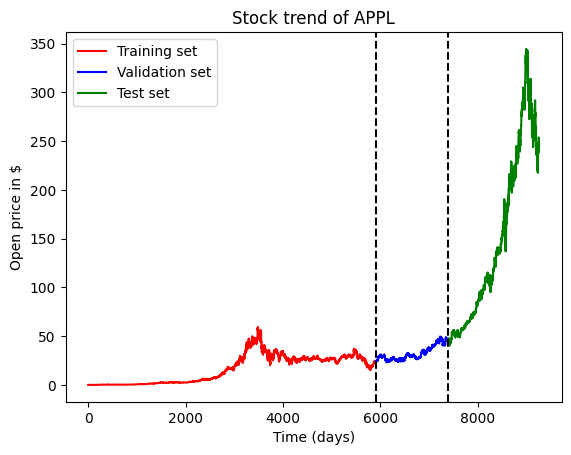

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df, window_size)
visualize_train_val_test(X_train, X_val, X_test)

In [15]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
X_val_norm, y_val_norm = MinMax_normalize(X_val, y_val)
X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

### 1.1.1 Bi-LSTM model

In [16]:
BiLSTM_history = BiLSTM_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 11s 787ms/step - loss: 0.1415 - mse: 0.1415 - val_loss: 0.1107 - val_mse: 0.1107
Epoch 2/200
2/2 [==============================] - 0s 53ms/step - loss: 0.1187 - mse: 0.1187 - val_loss: 0.0972 - val_mse: 0.0972
Epoch 3/200
2/2 [==============================] - 0s 52ms/step - loss: 0.0955 - mse: 0.0955 - val_loss: 0.0967 - val_mse: 0.0967
Epoch 4/200
2/2 [==============================] - 0s 65ms/step - loss: 0.0920 - mse: 0.0920 - val_loss: 0.0790 - val_mse: 0.0790
Epoch 5/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0785 - mse: 0.0785 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 7/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0616 - mse: 0.0616 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 8/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0566 - mse: 0.

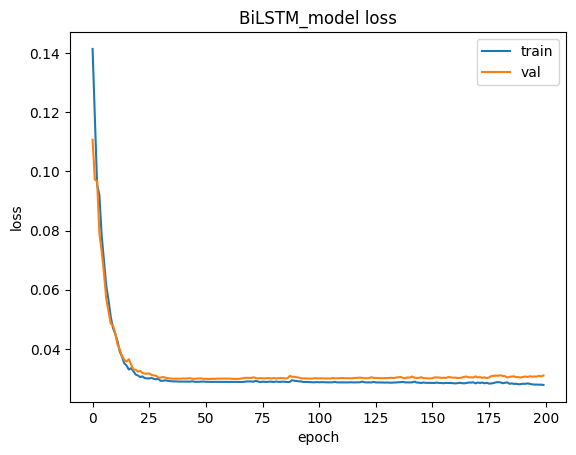

In [17]:
# Visualize the training and validation loss over epochs
plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])
plt.title('BiLSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

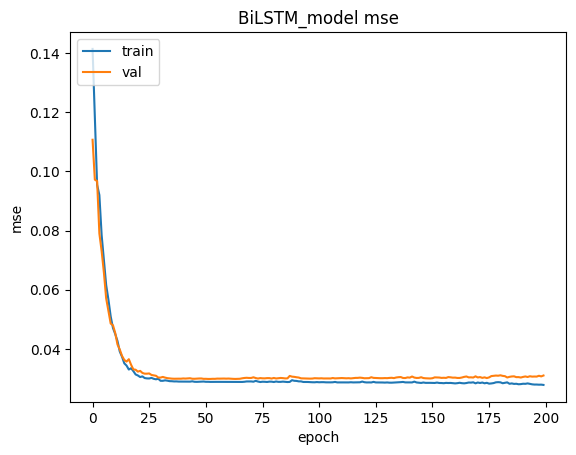

In [18]:
# Visualize the training and validation accuracy over epochs
plt.plot(BiLSTM_history.history['mse'])
plt.plot(BiLSTM_history.history['val_mse'])
plt.title('BiLSTM_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
# Get prediction on the test data
y_pred_norm = BiLSTM_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

58/58 [==============================] - 1s 4ms/step
MSE on the test set:  0.03426423507570101


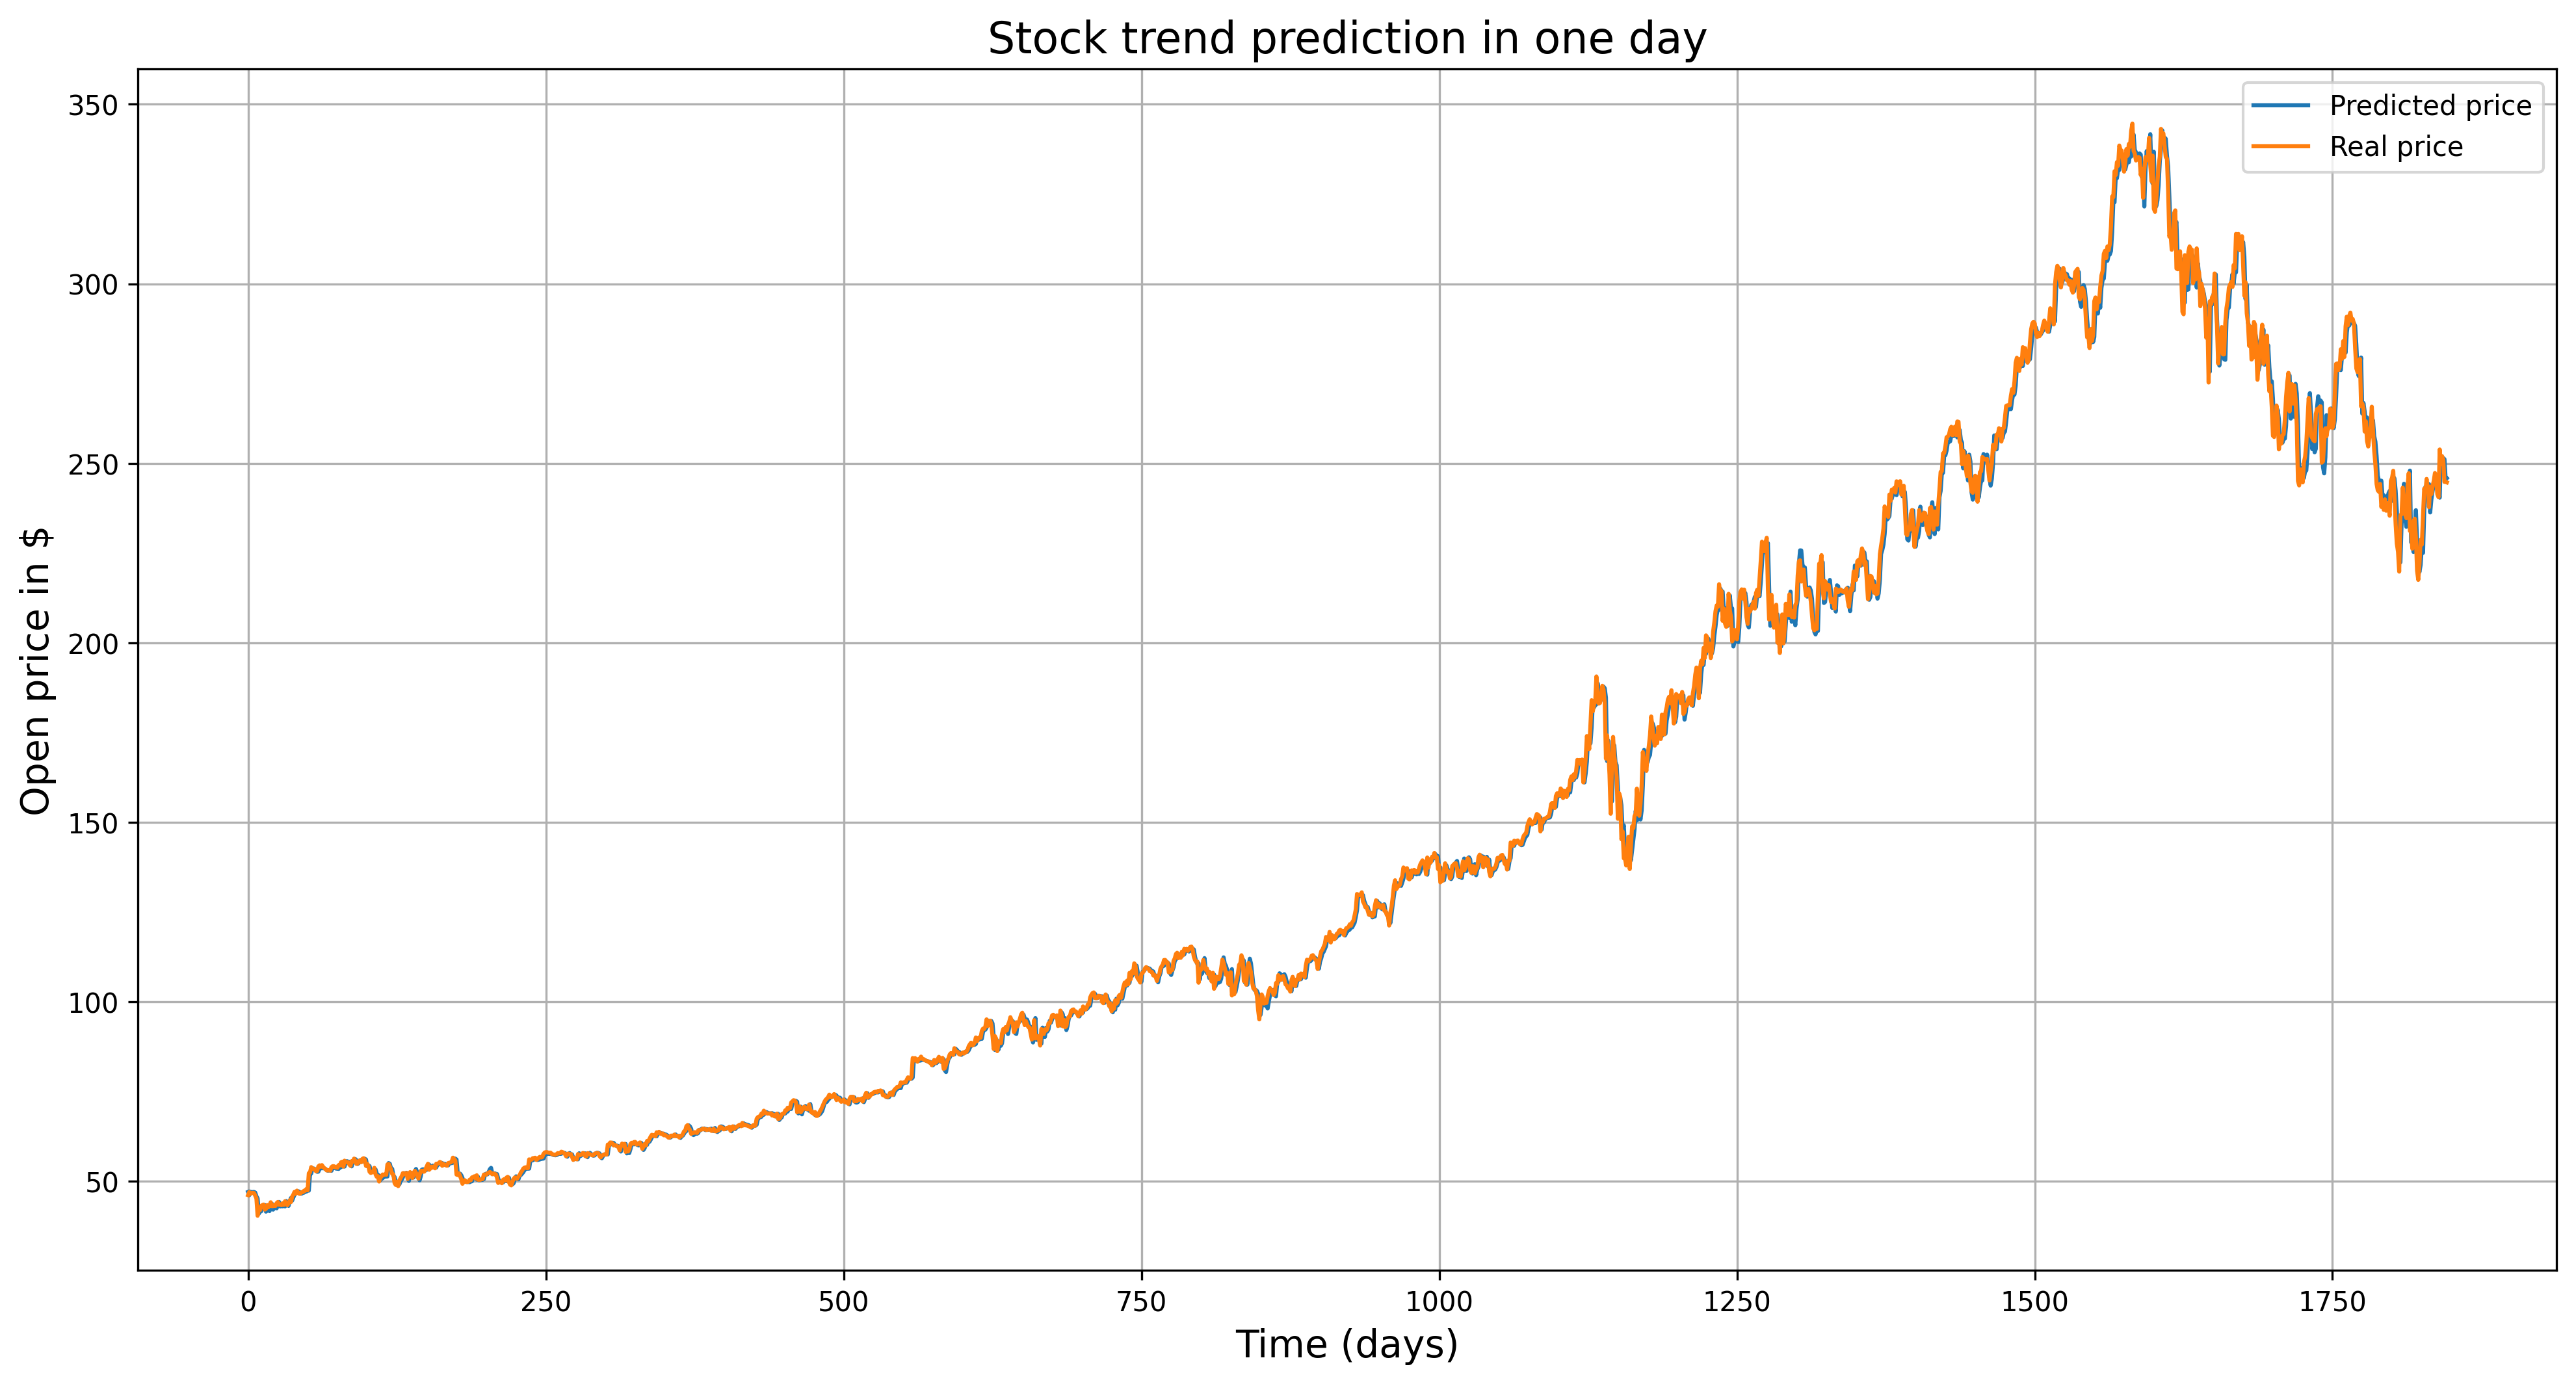

In [20]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.2 GRU model

In [21]:
GRU_history = GRU_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 7s 691ms/step - loss: 0.1520 - mse: 0.1520 - val_loss: 0.1262 - val_mse: 0.1262
Epoch 2/200
2/2 [==============================] - 0s 63ms/step - loss: 0.1201 - mse: 0.1201 - val_loss: 0.0918 - val_mse: 0.0918
Epoch 3/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0930 - mse: 0.0930 - val_loss: 0.0729 - val_mse: 0.0729
Epoch 4/200
2/2 [==============================] - 0s 53ms/step - loss: 0.0804 - mse: 0.0804 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 5/200
2/2 [==============================] - 0s 55ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 6/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0716 - mse: 0.0716 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 7/200
2/2 [==============================] - 0s 48ms/step - loss: 0.0568 - mse: 0.0568 - val_loss: 0.0631 - val_mse: 0.0631
Epoch 8/200
2/2 [==============================] - 0s 45ms/step - loss: 0.0595 - mse: 0.0

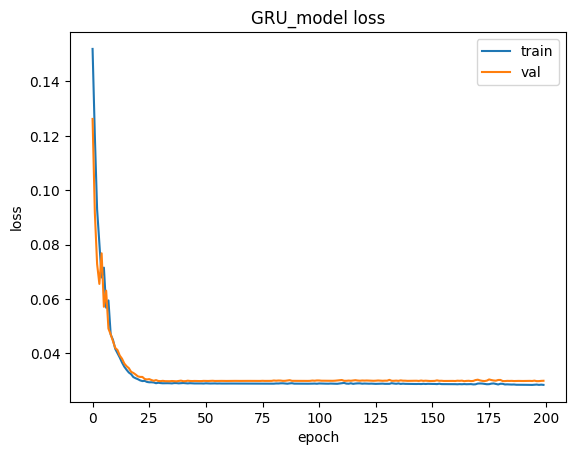

In [22]:
# Visualize the training and validation loss over epochs
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('GRU_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

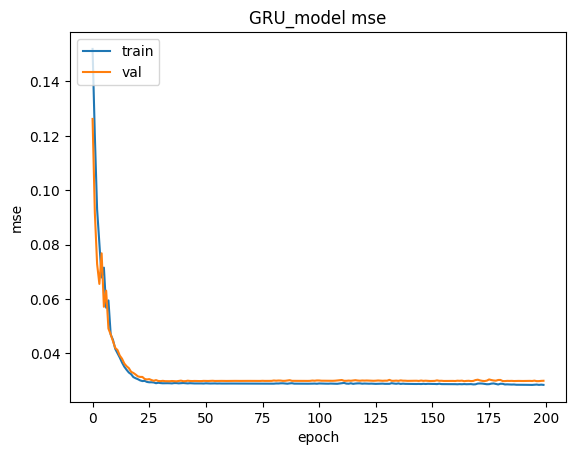

In [23]:
# Visualize the training and validation accuracy over epochs
plt.plot(GRU_history.history['mse'])
plt.plot(GRU_history.history['val_mse'])
plt.title('GRU_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

58/58 [==============================] - 1s 4ms/step
MSE on the test set:  0.0337130254888232


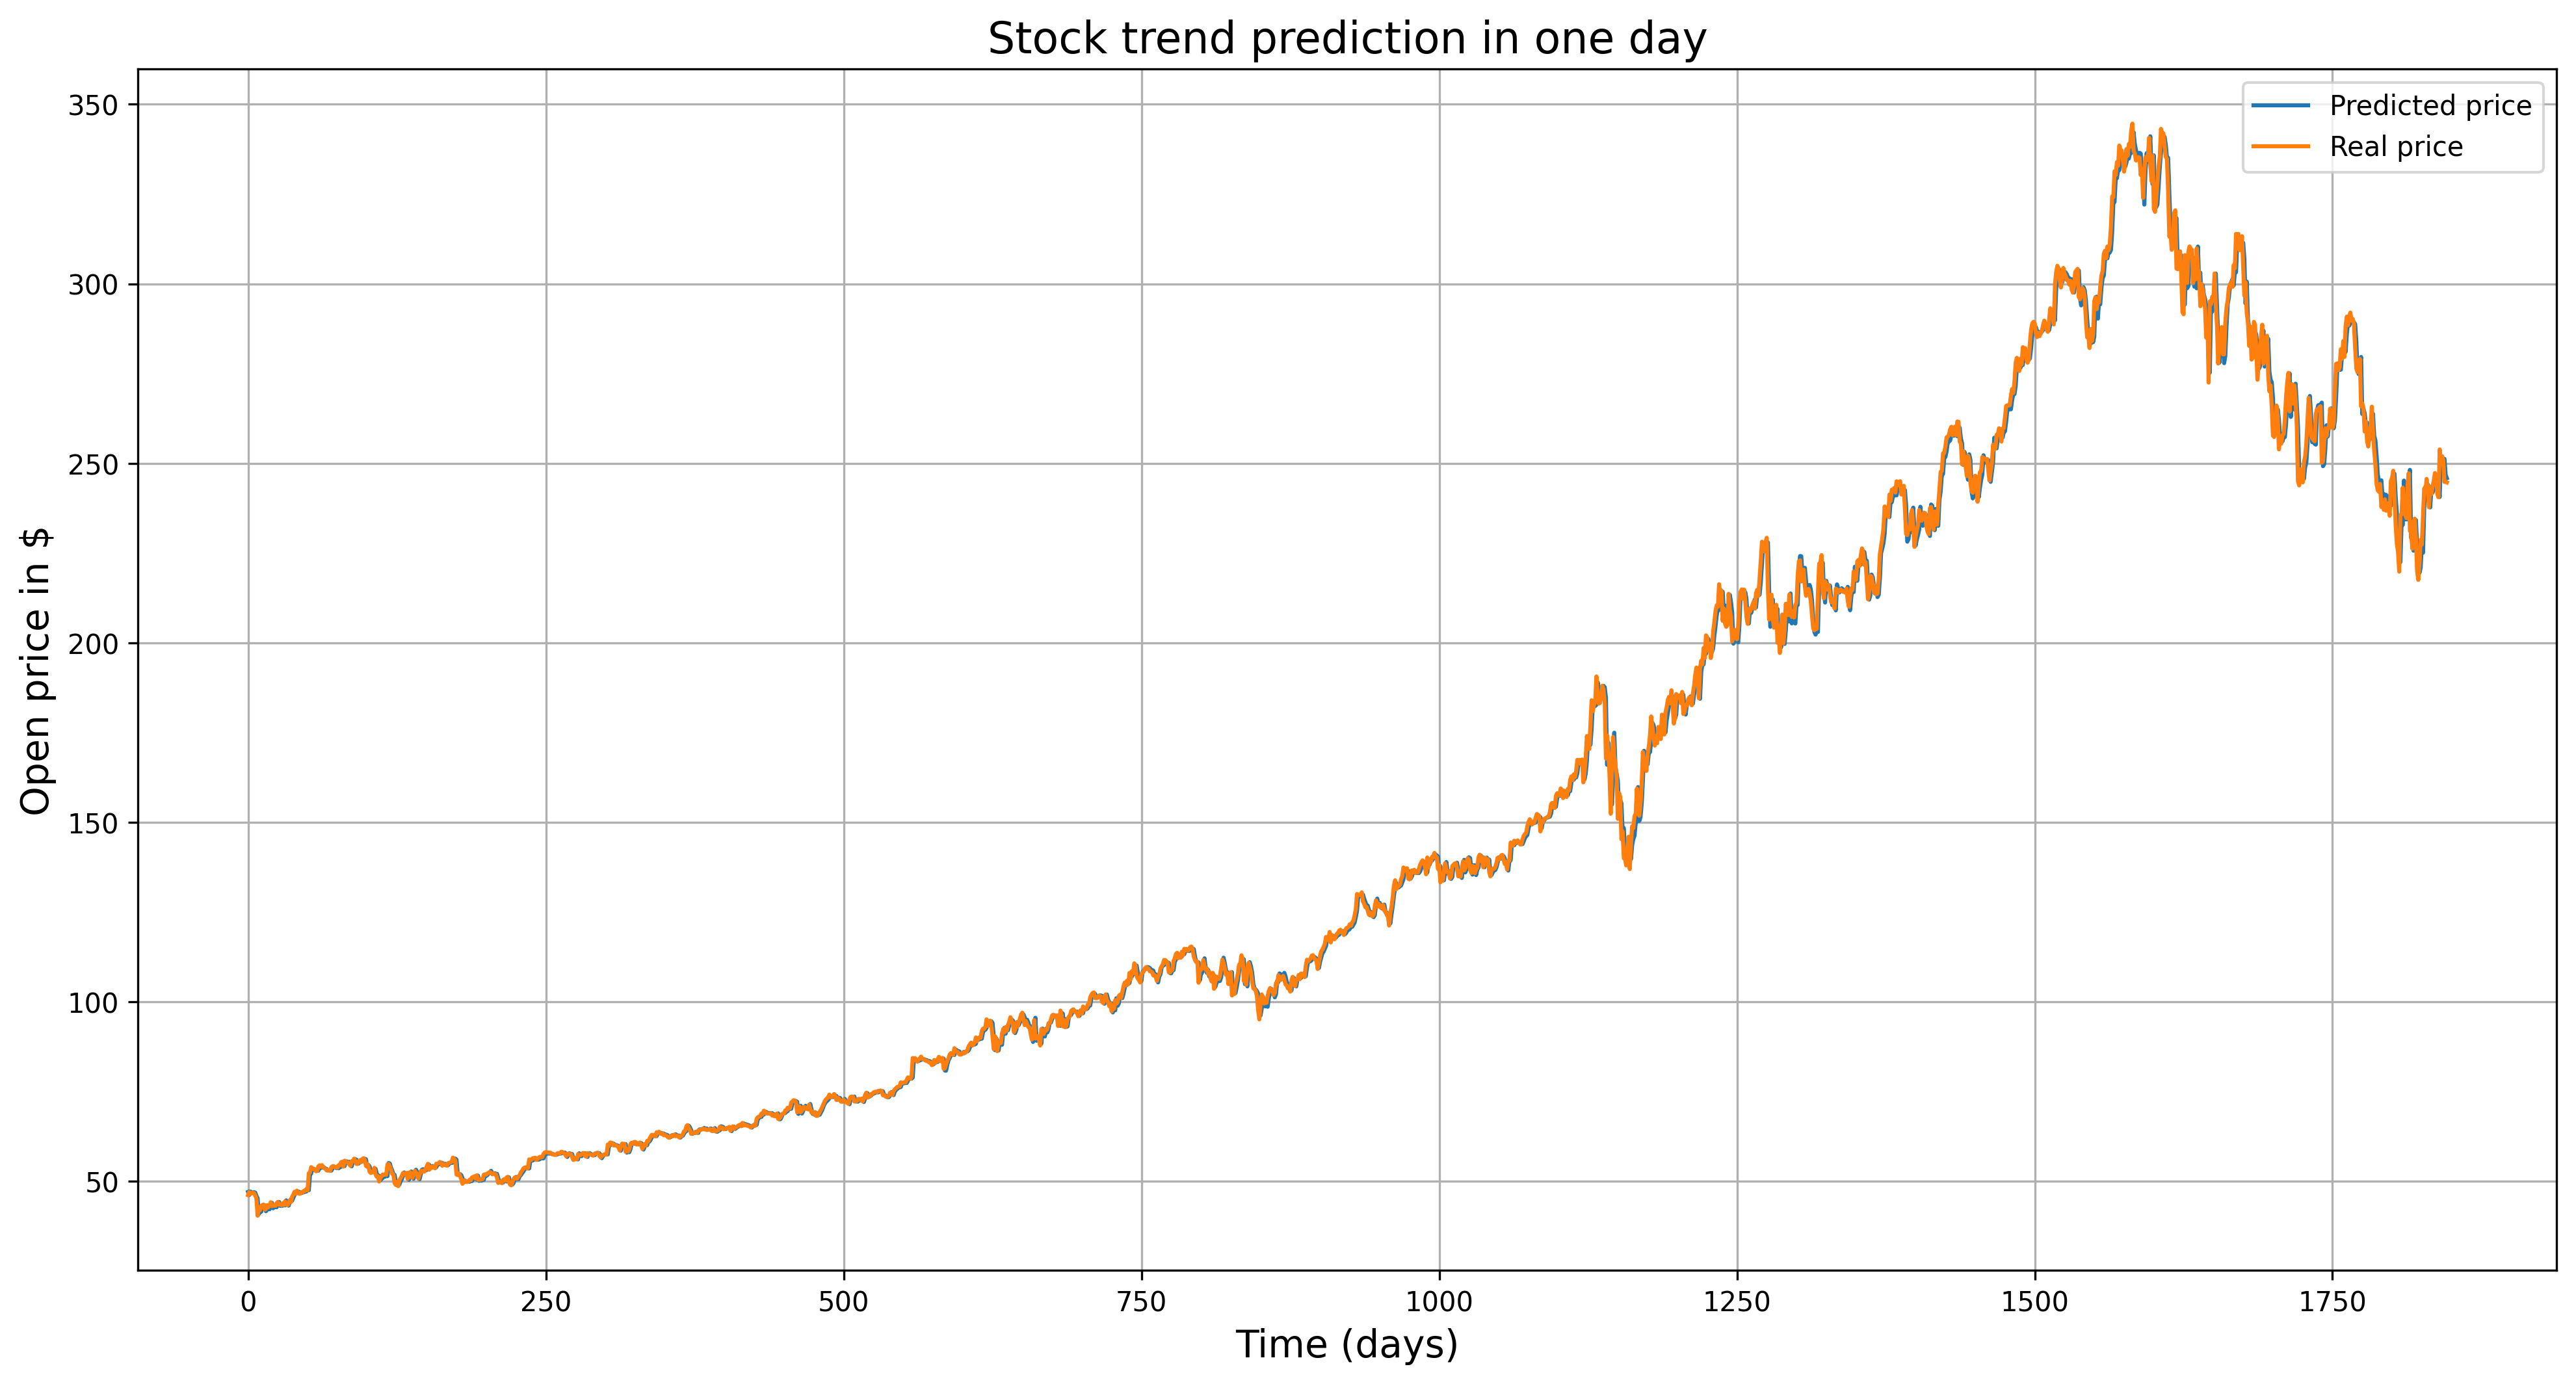

In [25]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.3 Conv1D model

In [26]:
Conv1D_history = Conv1D_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 6s 261ms/step - loss: 0.1528 - mse: 0.1528 - val_loss: 0.1477 - val_mse: 0.1477
Epoch 2/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1480 - mse: 0.1480 - val_loss: 0.1478 - val_mse: 0.1478
Epoch 3/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1479 - mse: 0.1479 - val_loss: 0.1466 - val_mse: 0.1466
Epoch 4/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1466 - mse: 0.1466 - val_loss: 0.1449 - val_mse: 0.1449
Epoch 5/200
2/2 [==============================] - 0s 48ms/step - loss: 0.1450 - mse: 0.1450 - val_loss: 0.1438 - val_mse: 0.1438
Epoch 6/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1438 - mse: 0.1438 - val_loss: 0.1423 - val_mse: 0.1423
Epoch 7/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1422 - mse: 0.1422 - val_loss: 0.1406 - val_mse: 0.1406
Epoch 8/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1403 - mse: 0.1

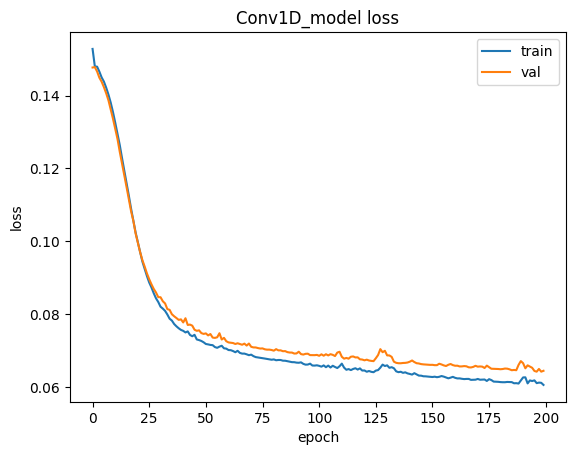

In [27]:
# Visualize the training and validation loss over epochs
plt.plot(Conv1D_history.history['loss'])
plt.plot(Conv1D_history.history['val_loss'])
plt.title('Conv1D_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

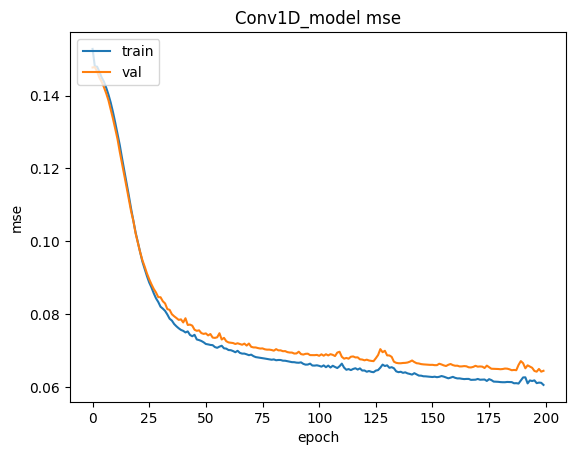

In [28]:
# Visualize the training and validation accuracy over epochs
plt.plot(Conv1D_history.history['mse'])
plt.plot(Conv1D_history.history['val_mse'])
plt.title('Conv1D_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
# Get prediction on the test data
y_pred_norm = Conv1D_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

58/58 [==============================] - 0s 2ms/step
MSE on the test set:  0.060555183861104485


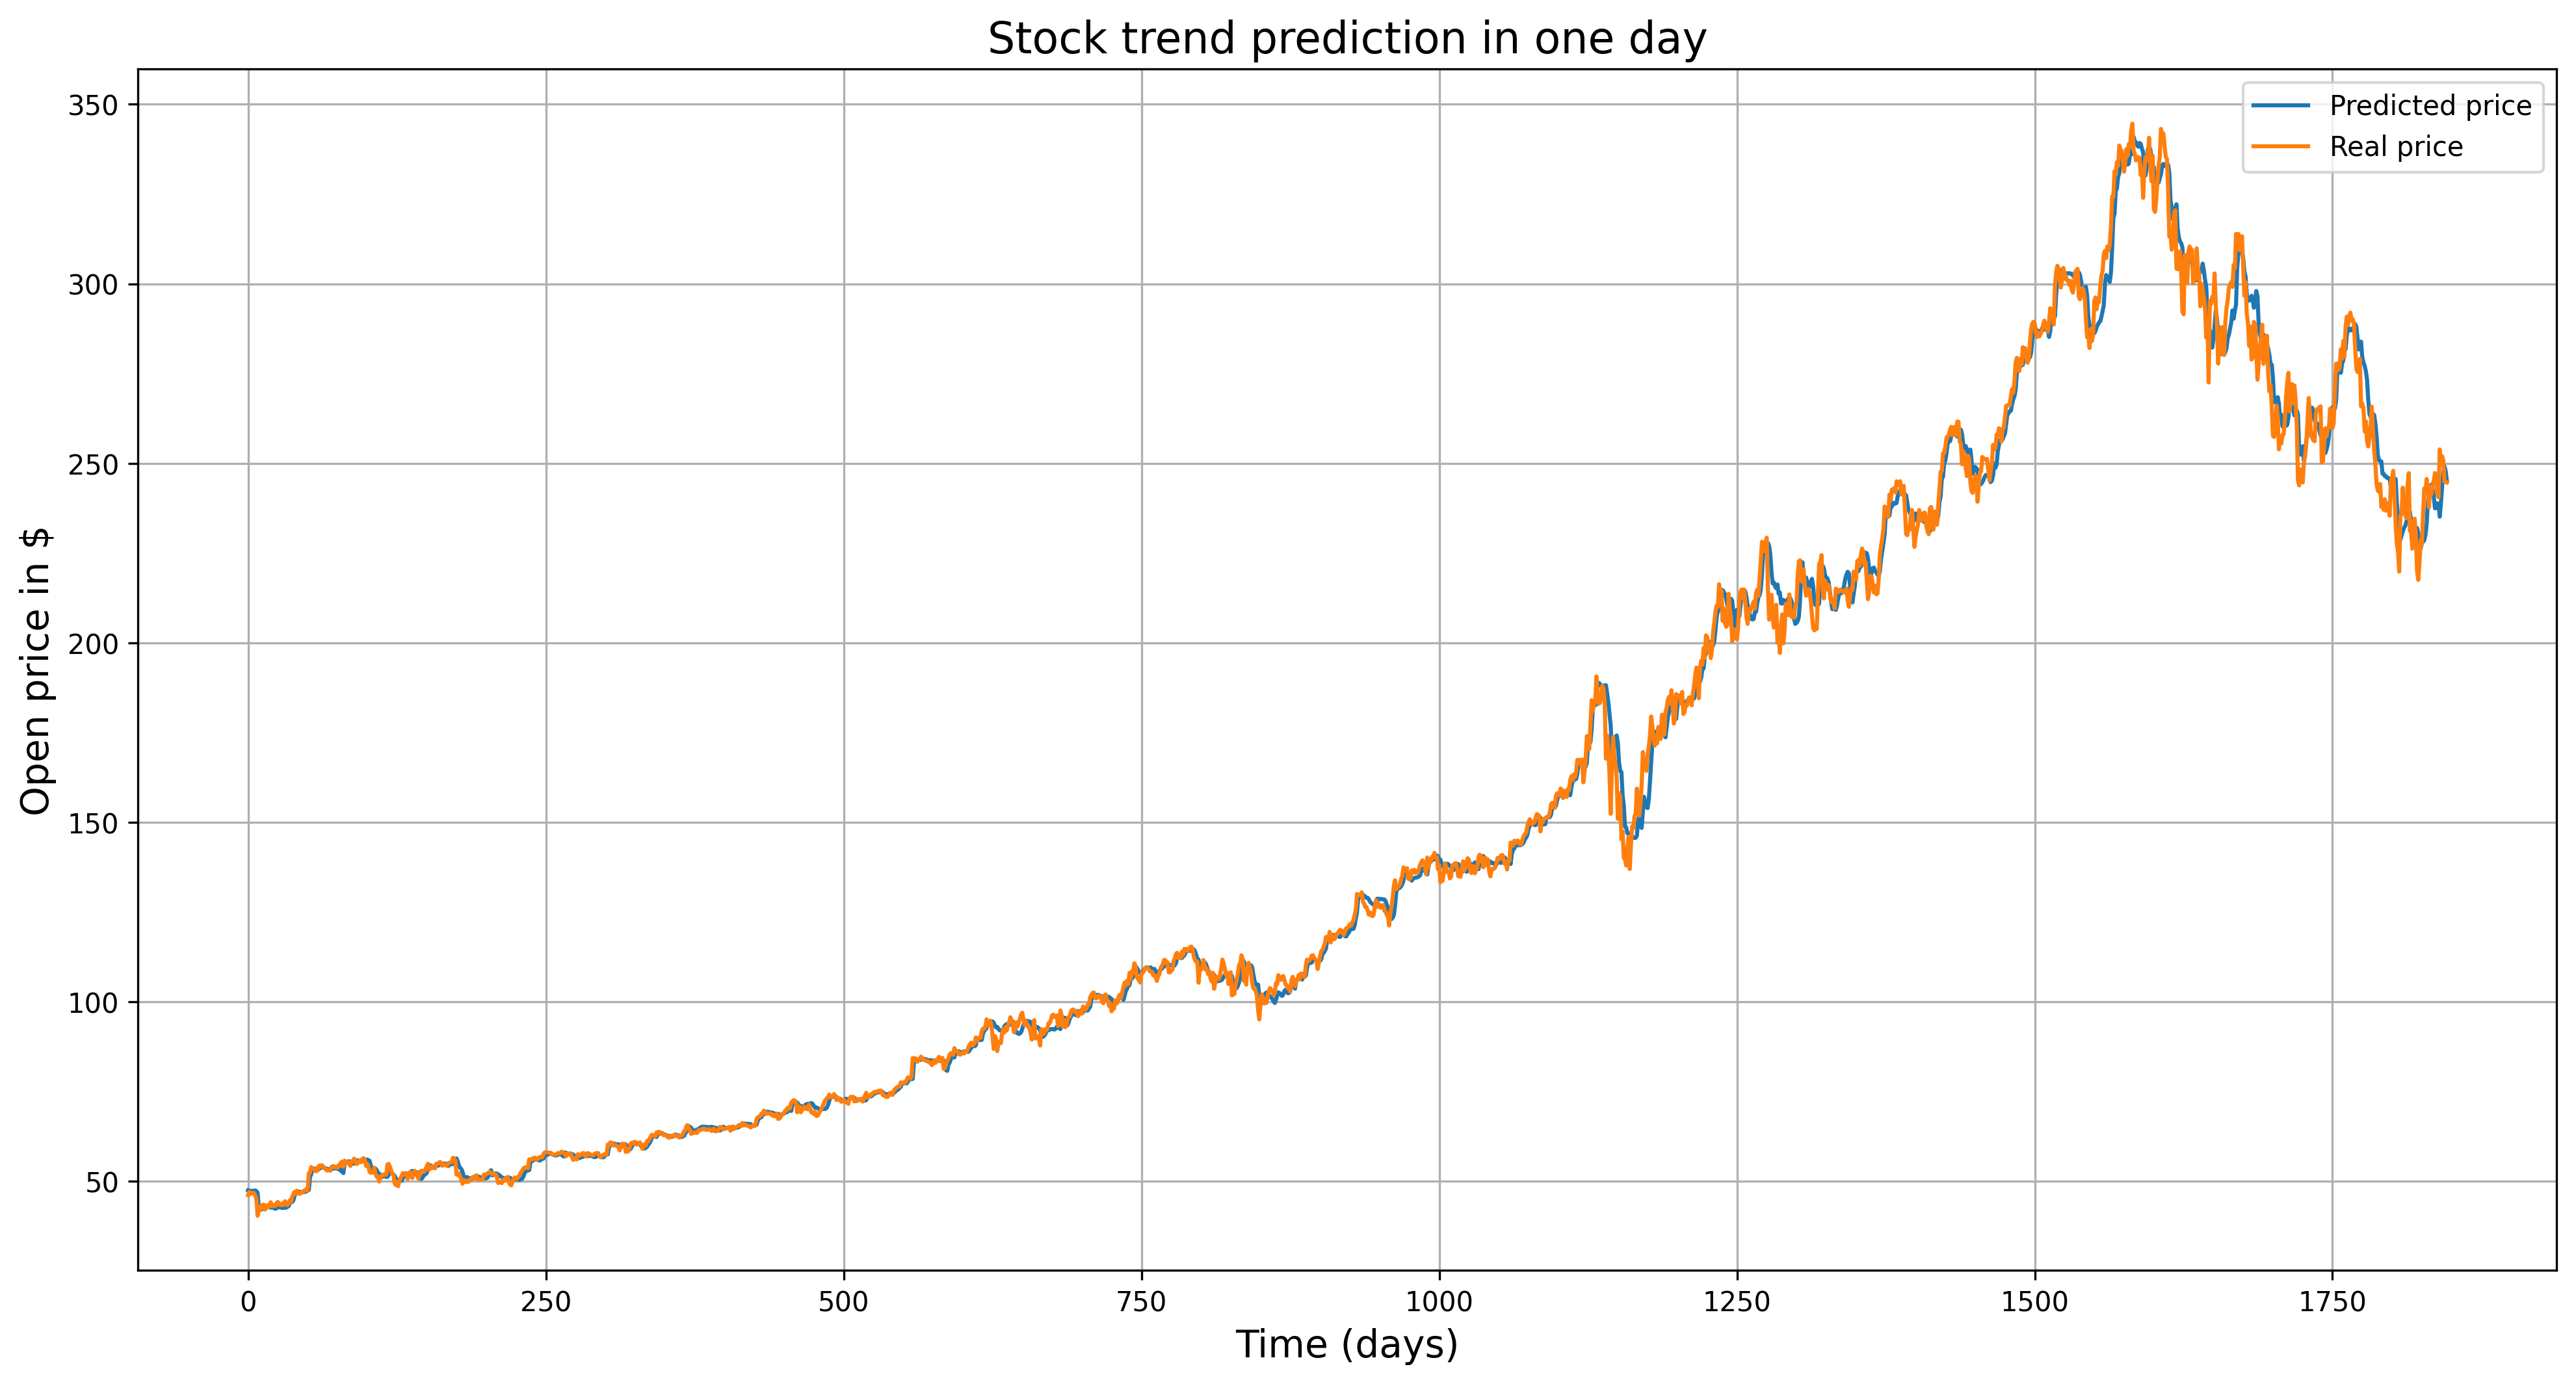

In [30]:
pred_real_visualize(y_pred_norm, X_test, y_test)

## 1.2 CROSS VALIDATION

In [31]:
X_data, y_data = preprocess_crossval(df, window_size)

# # Normalize the data
# X_data_norm, y_data_norm = MinMax_normalize(X_data, y_data)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=folds)

for train_index, test_index in tscv.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
    
    X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

    # Fit the model to the current training fold
    GRU_model.fit(X_train_norm, y_train_norm, epochs=epochs, batch_size=batch_size)
    
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

Epoch 1/200
1/1 [==============================] - 0s 24ms/step - loss: 0.0244 - mse: 0.0244
Epoch 2/200
1/1 [==============================] - 0s 20ms/step - loss: 0.0242 - mse: 0.0242
Epoch 3/200
1/1 [==============================] - 0s 20ms/step - loss: 0.0241 - mse: 0.0241
Epoch 4/200
1/1 [==============================] - 0s 20ms/step - loss: 0.0240 - mse: 0.0240
Epoch 5/200
1/1 [==============================] - 0s 19ms/step - loss: 0.0240 - mse: 0.0240
Epoch 6/200
1/1 [==============================] - 0s 19ms/step - loss: 0.0238 - mse: 0.0238
Epoch 7/200
1/1 [==============================] - 0s 19ms/step - loss: 0.0237 - mse: 0.0237
Epoch 8/200
1/1 [==============================] - 0s 20ms/step - loss: 0.0236 - mse: 0.0236
Epoch 9/200
1/1 [==============================] - 0s 21ms/step - loss: 0.0235 - mse: 0.0235
Epoch 10/200
1/1 [==============================] - 0s 22ms/step - loss: 0.0235 - mse: 0.0235
Epoch 11/200
1/1 [==============================] - 0s 20ms/step - lo

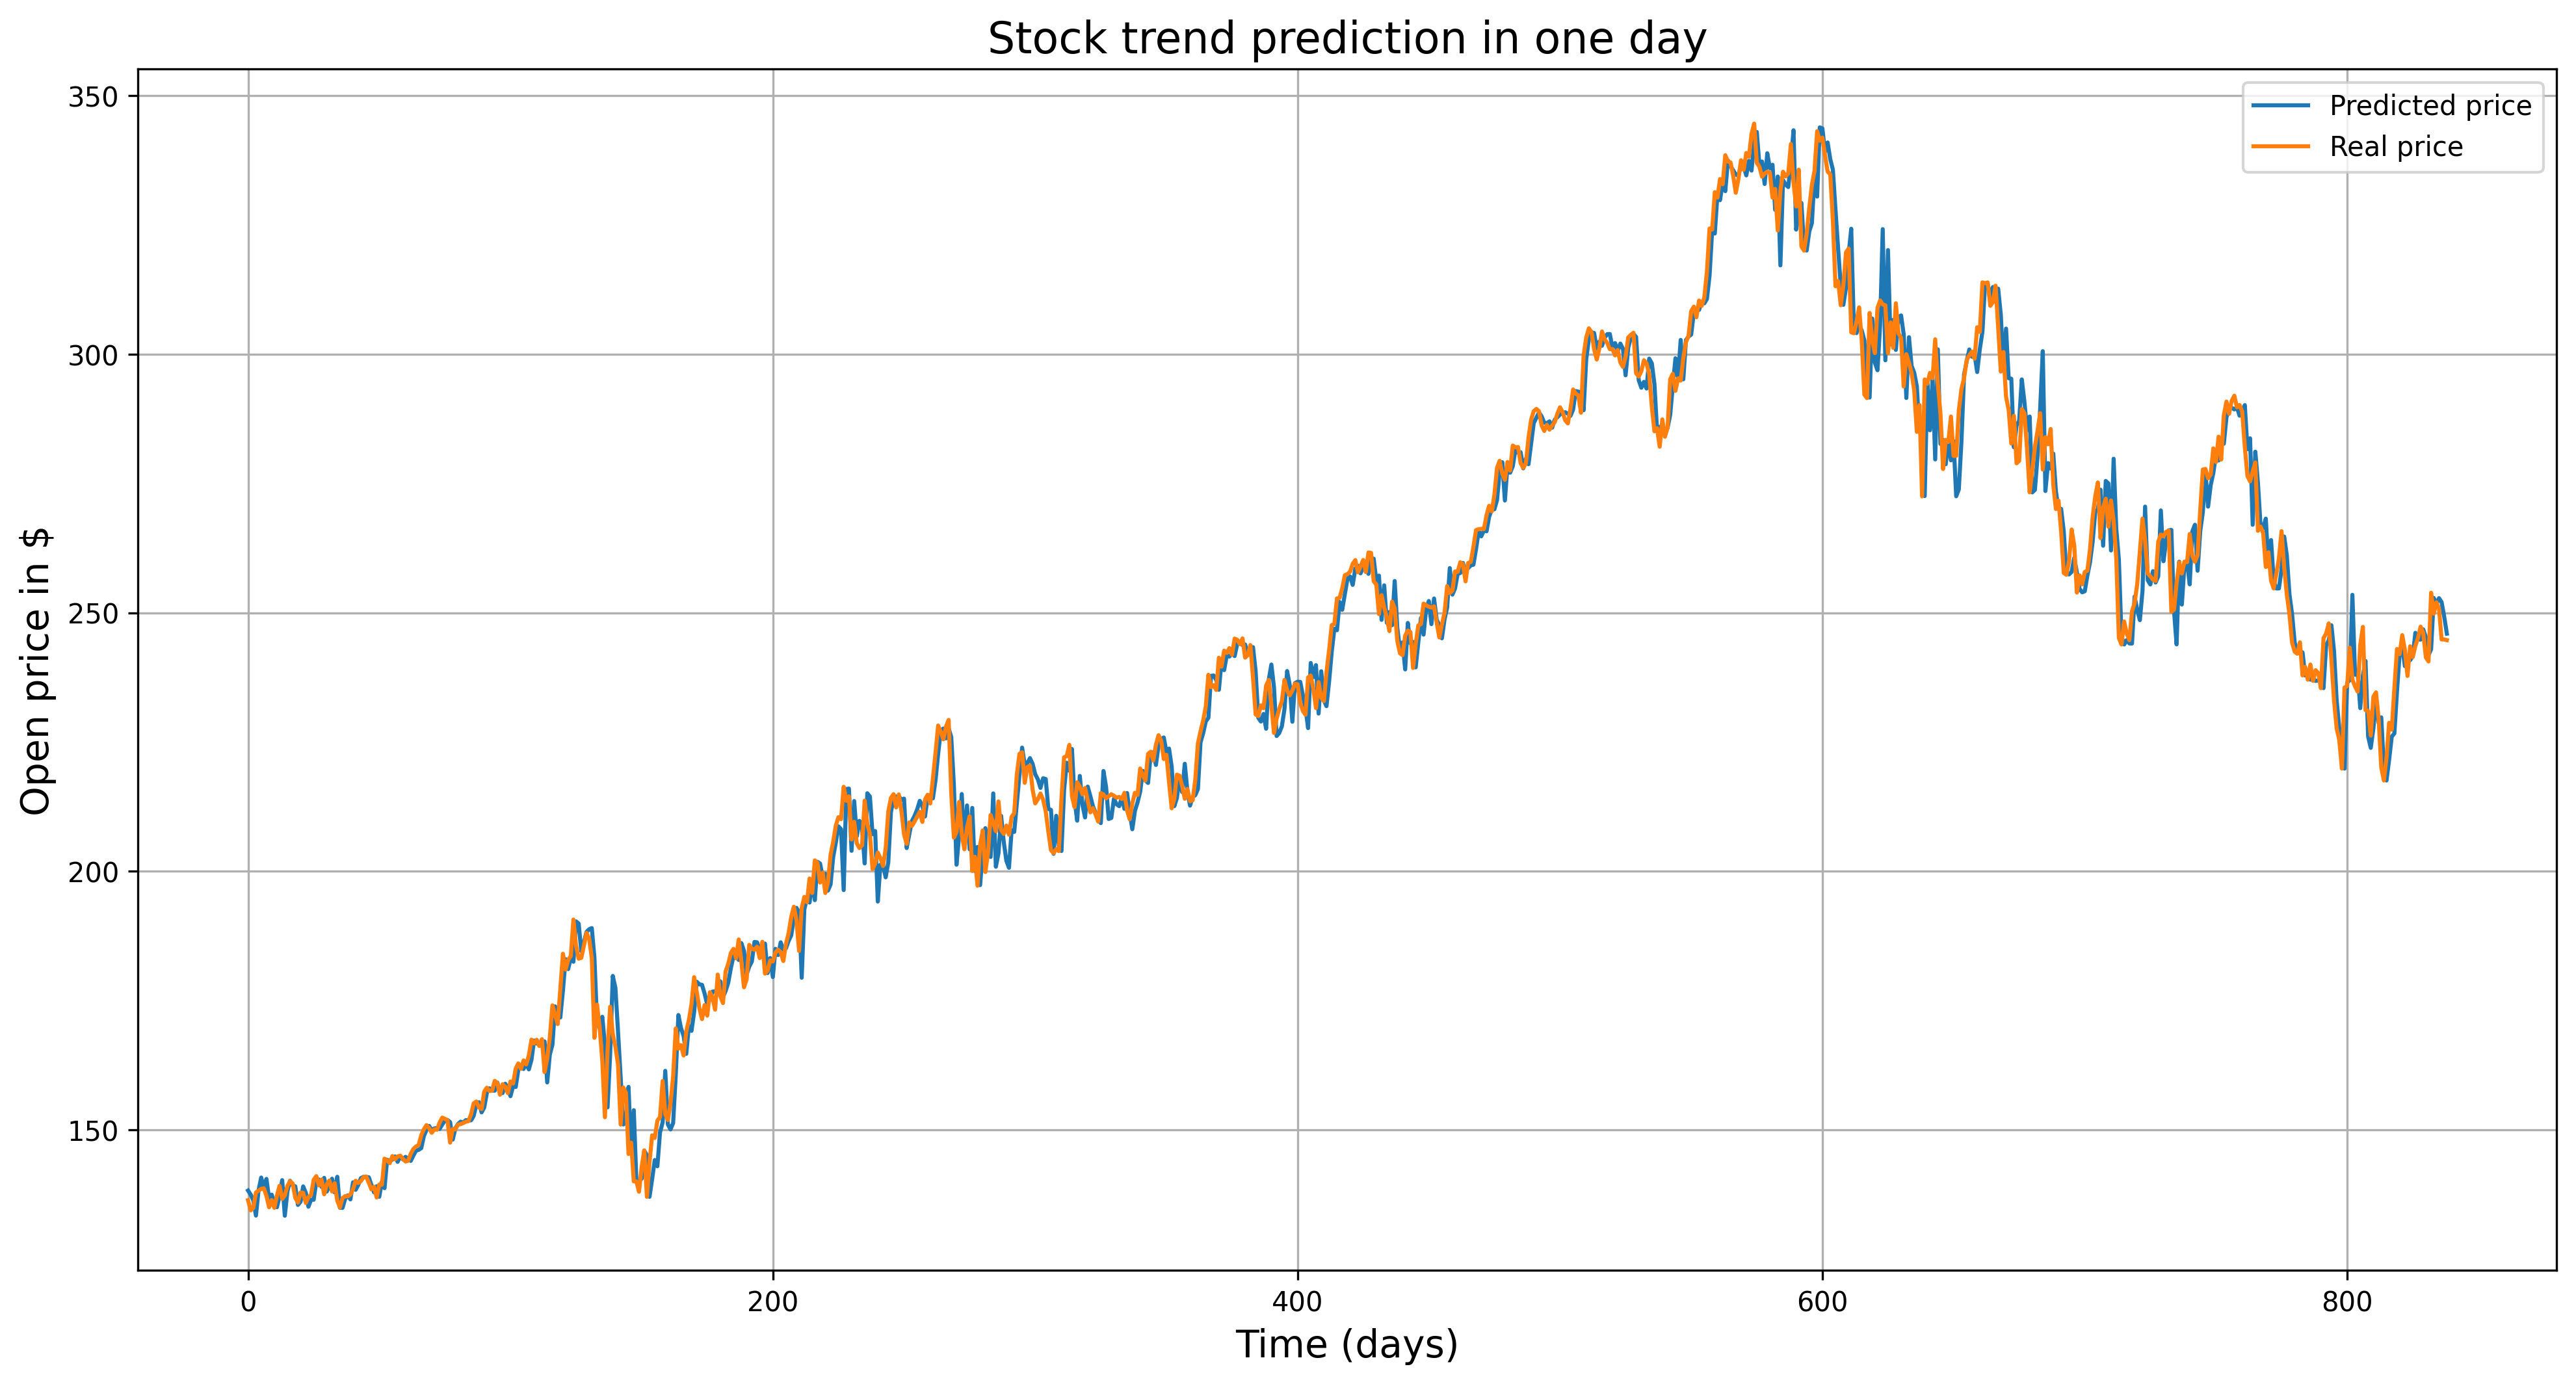

In [32]:
pred_real_visualize(y_pred_norm, X_test, y_test)

# 2. Time windows = 252 days

In [33]:
window_size = 252
epochs = 200
batch_size = 4096
folds = 10

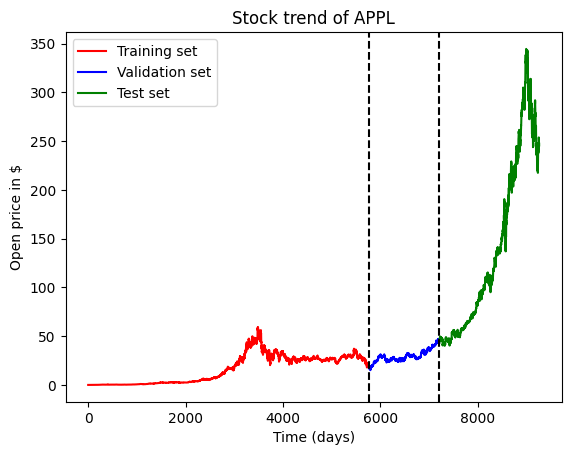

In [34]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df, window_size)
visualize_train_val_test(X_train, X_val, X_test)

In [35]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
X_val_norm, y_val_norm = MinMax_normalize(X_val, y_val)
X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

## 1.1 Training - Validation - Test split

### 1.1.1 Bi-LSTM model

In [36]:
BiLSTM_history = BiLSTM_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 3s 895ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 2/200
2/2 [==============================] - 0s 155ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/200
2/2 [==============================] - 0s 181ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 4/200
2/2 [==============================] - 0s 181ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/200
2/2 [==============================] - 0s 153ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 6/200
2/2 [==============================] - 0s 153ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/200
2/2 [==============================] - 0s 181ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/200
2/2 [==============================] - 0s 155ms/step - loss: 0.0039 - m

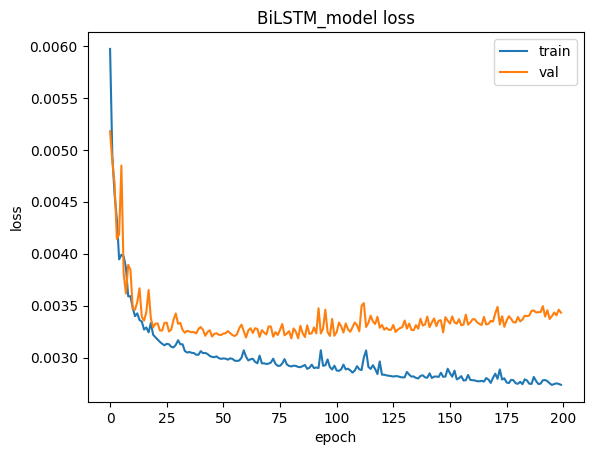

In [37]:
# Visualize the training and validation loss over epochs
plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])
plt.title('BiLSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

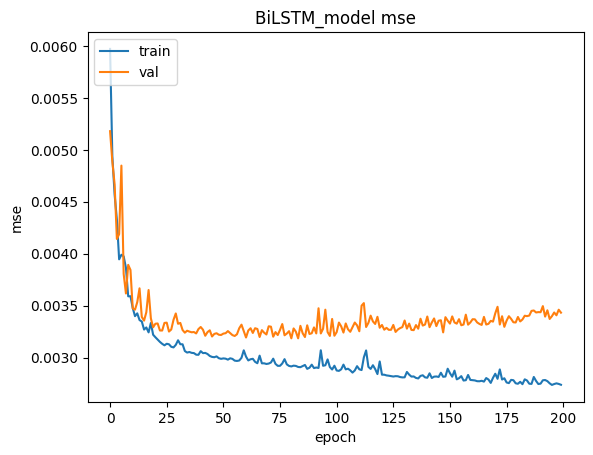

In [38]:
# Visualize the training and validation accuracy over epochs
plt.plot(BiLSTM_history.history['mse'])
plt.plot(BiLSTM_history.history['val_mse'])
plt.title('BiLSTM_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
# Get prediction on the test data
y_pred_norm = BiLSTM_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

57/57 [==============================] - 1s 9ms/step
MSE on the test set:  0.0027768011530838236


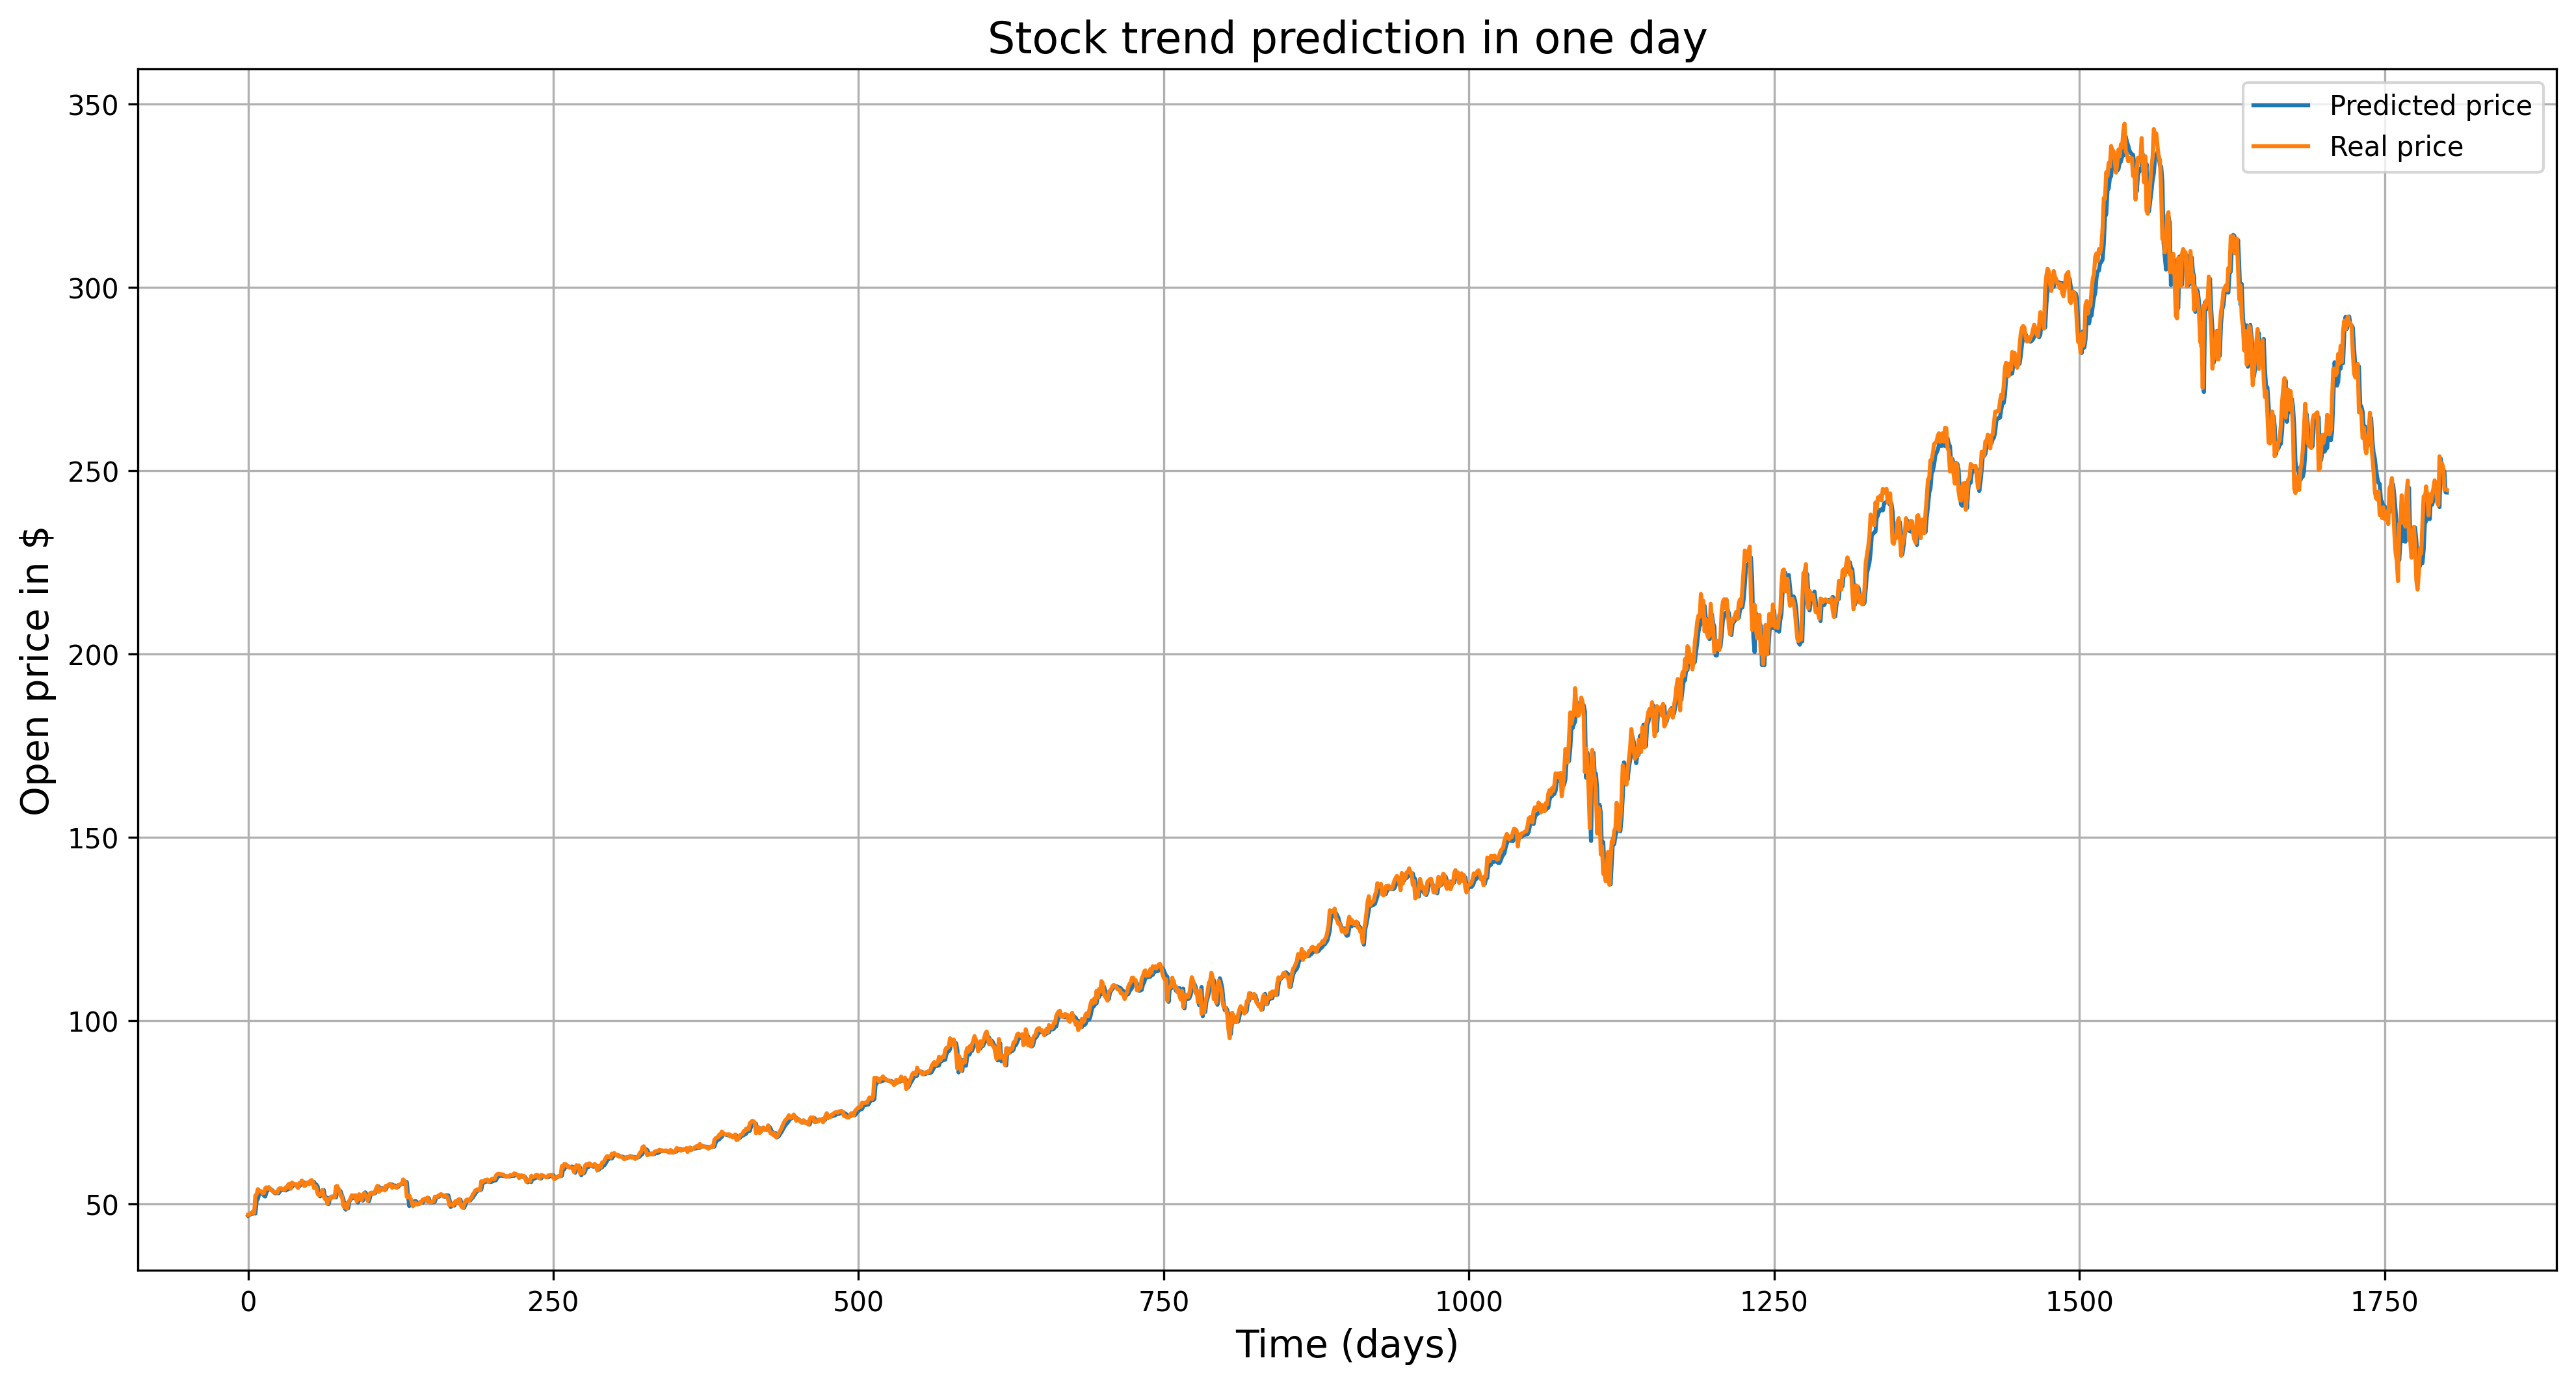

In [40]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.2 GRU model

In [41]:
GRU_history = GRU_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 3s 766ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 2/200
2/2 [==============================] - 0s 139ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 3/200
2/2 [==============================] - 0s 138ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 4/200
2/2 [==============================] - 0s 137ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 5/200
2/2 [==============================] - 0s 142ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 6/200
2/2 [==============================] - 0s 138ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 7/200
2/2 [==============================] - 0s 137ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 8/200
2/2 [==============================] - 0s 139ms/step - loss: 0.0124 - m

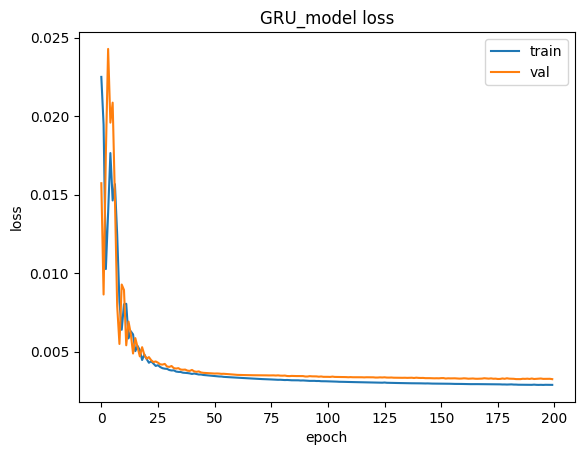

In [42]:
# Visualize the training and validation loss over epochs
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('GRU_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

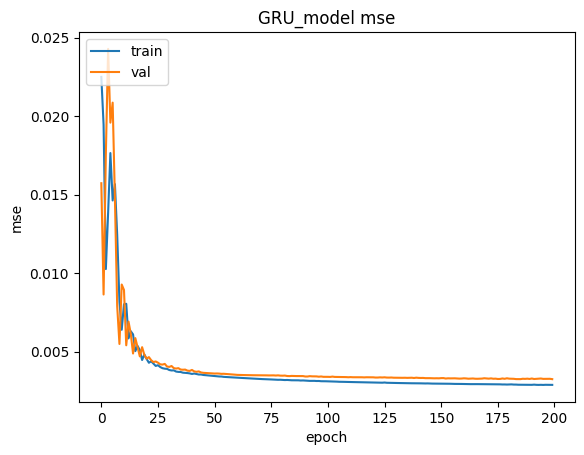

In [43]:
# Visualize the training and validation accuracy over epochs
plt.plot(GRU_history.history['mse'])
plt.plot(GRU_history.history['val_mse'])
plt.title('GRU_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

57/57 [==============================] - 1s 7ms/step
MSE on the test set:  0.0027897742815998976


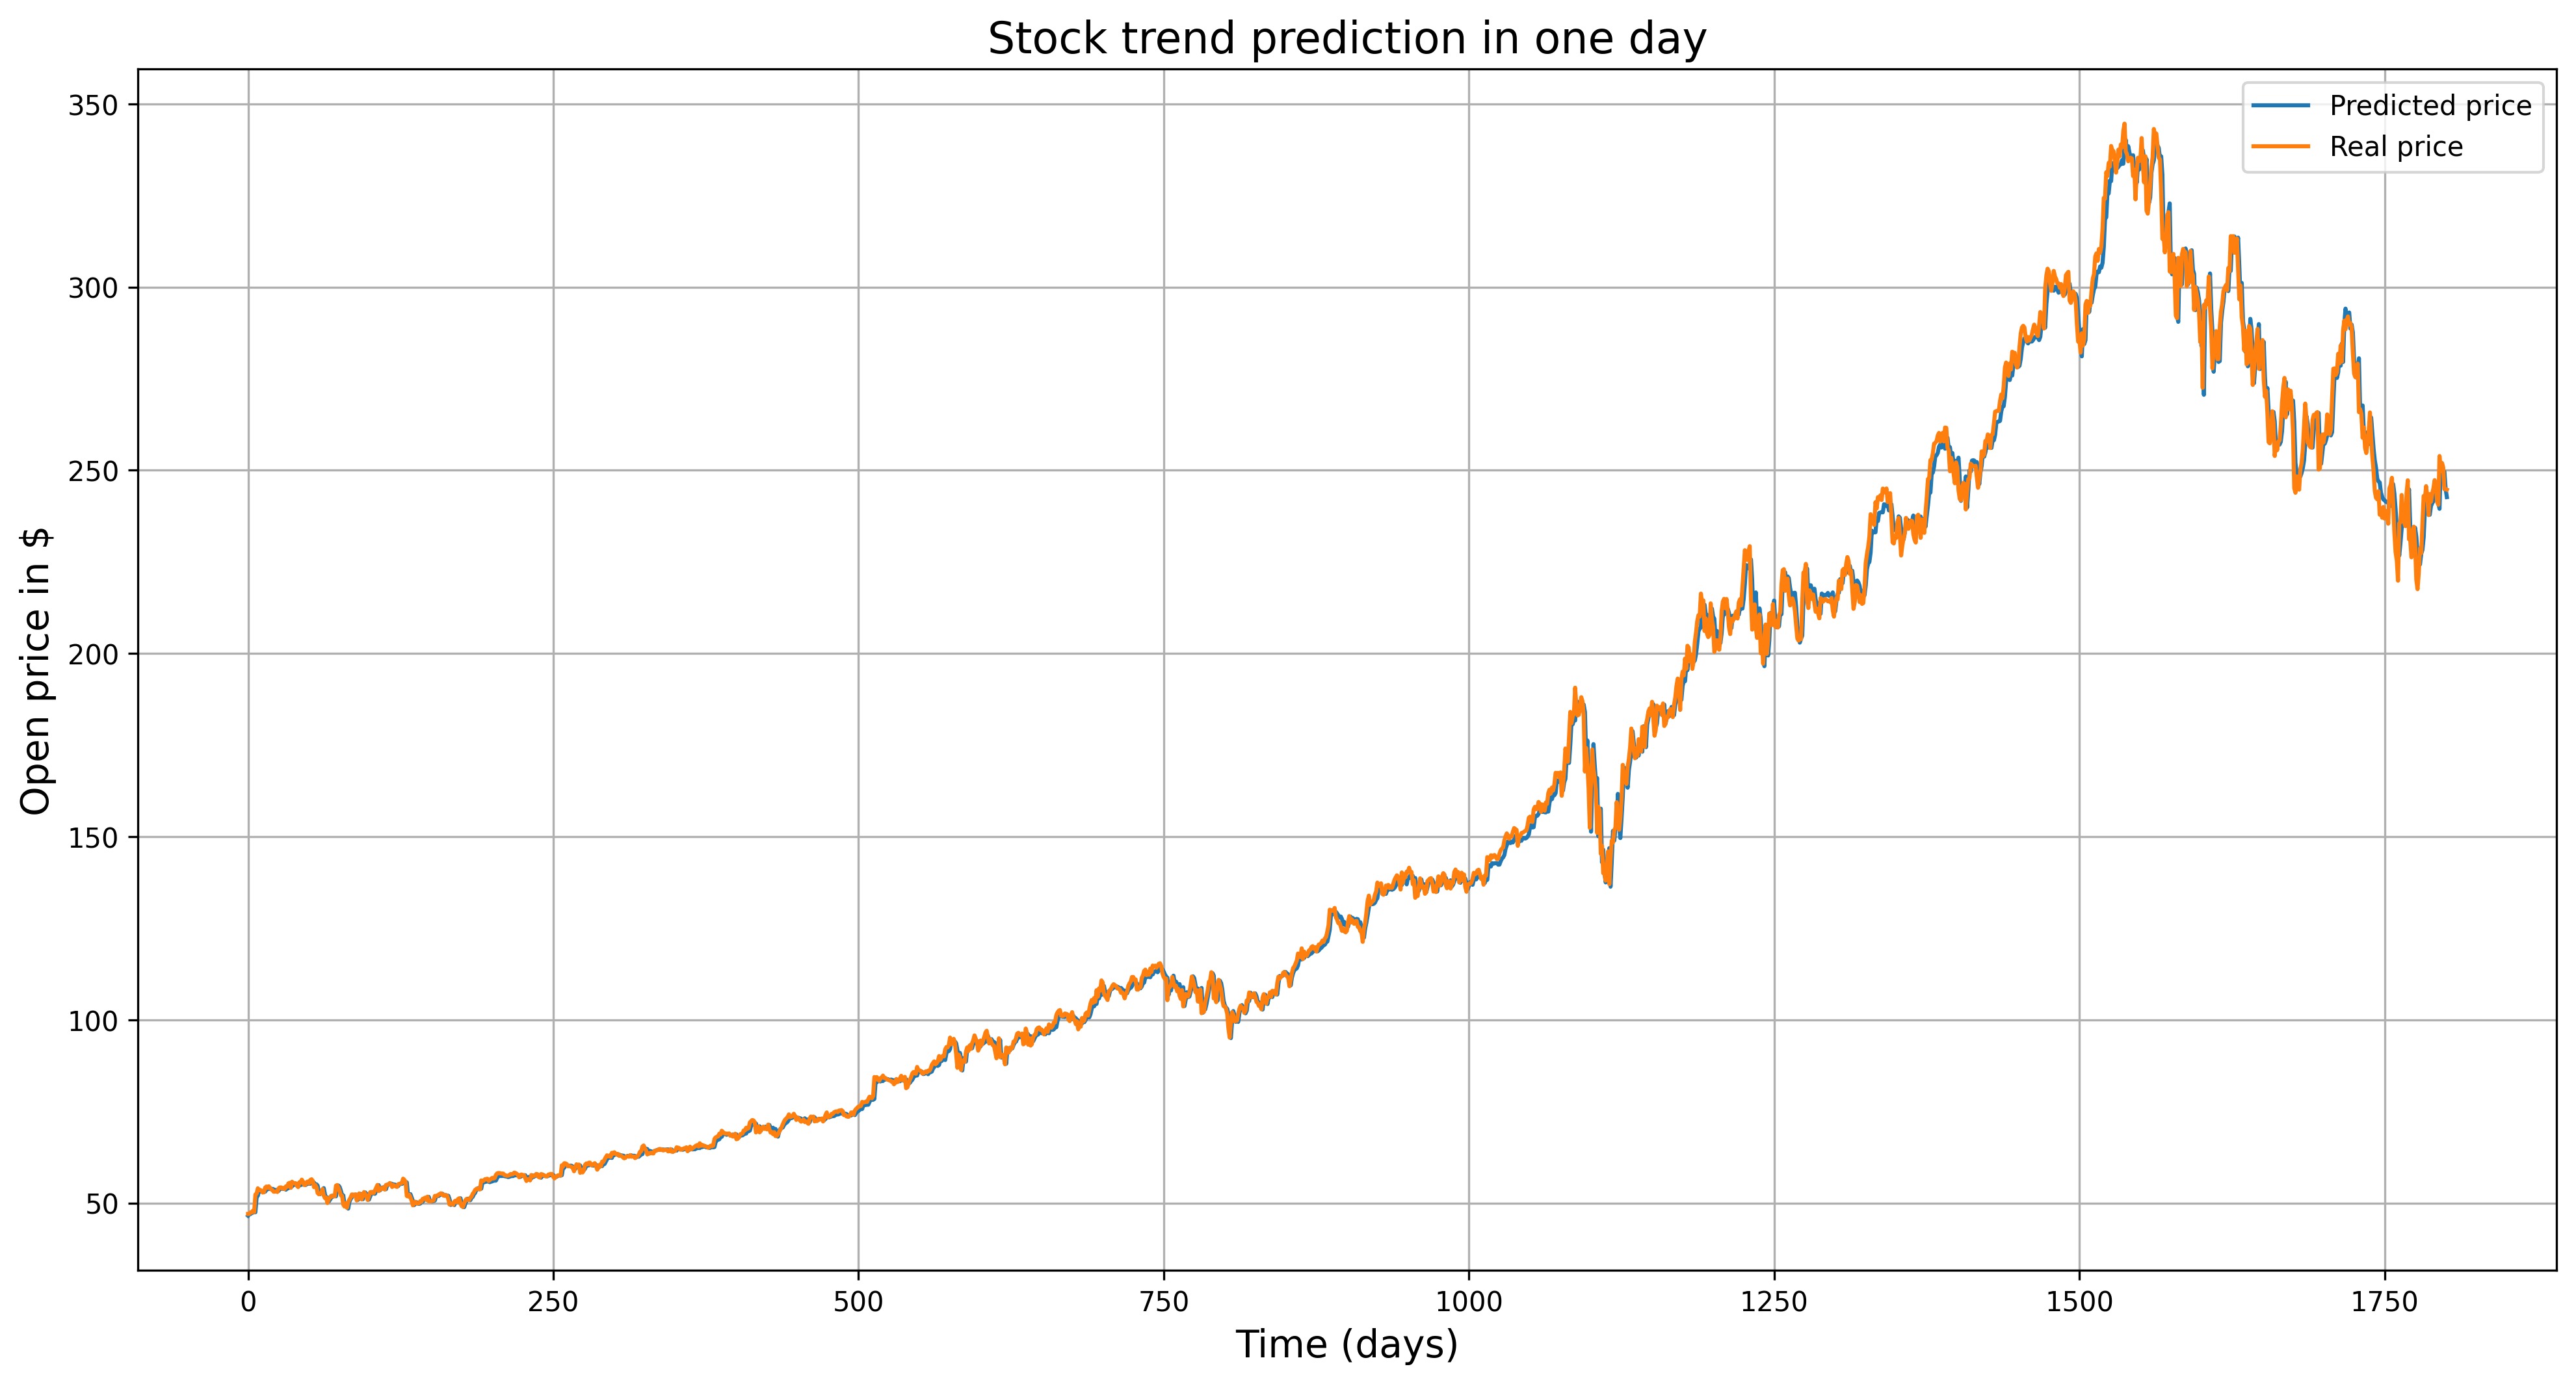

In [45]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.3 Conv1D model

In [46]:
Conv1D_history = Conv1D_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 1s 259ms/step - loss: 0.1174 - mse: 0.1174 - val_loss: 0.1770 - val_mse: 0.1770
Epoch 2/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1597 - mse: 0.1597 - val_loss: 0.1183 - val_mse: 0.1183
Epoch 3/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1367 - mse: 0.1367 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 4/200
2/2 [==============================] - 0s 44ms/step - loss: 0.0912 - mse: 0.0912 - val_loss: 0.1238 - val_mse: 0.1238
Epoch 5/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1183 - mse: 0.1183 - val_loss: 0.0679 - val_mse: 0.0679
Epoch 6/200
2/2 [==============================] - 0s 44ms/step - loss: 0.0901 - mse: 0.0901 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 7/200
2/2 [==============================] - 0s 45ms/step - loss: 0.0907 - mse: 0.0907 - val_loss: 0.0931 - val_mse: 0.0931
Epoch 8/200
2/2 [==============================] - 0s 43ms/step - loss: 0.0982 - mse: 0.0

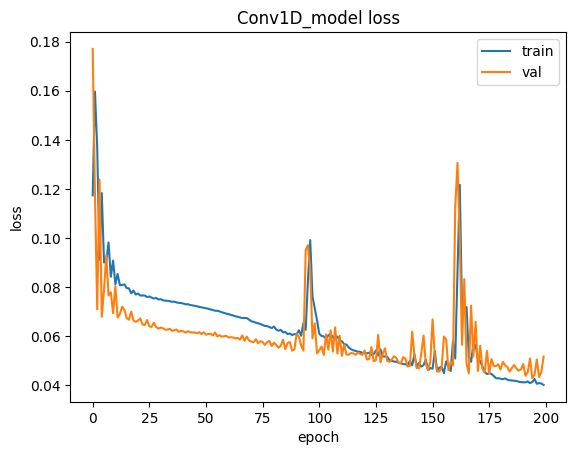

In [47]:
# Visualize the training and validation loss over epochs
plt.plot(Conv1D_history.history['loss'])
plt.plot(Conv1D_history.history['val_loss'])
plt.title('Conv1D_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

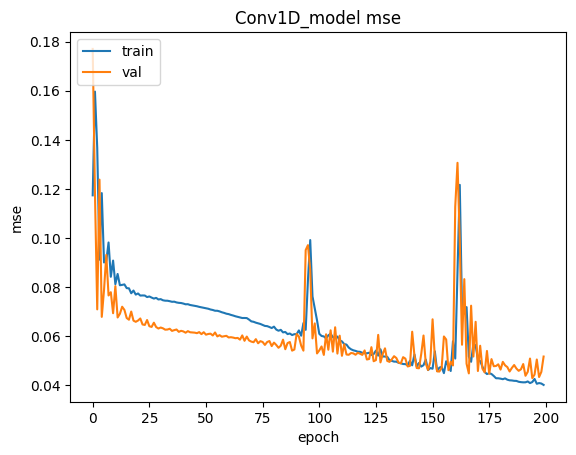

In [48]:
# Visualize the training and validation accuracy over epochs
plt.plot(Conv1D_history.history['mse'])
plt.plot(Conv1D_history.history['val_mse'])
plt.title('Conv1D_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
# Get prediction on the test data
y_pred_norm = Conv1D_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

57/57 [==============================] - 0s 3ms/step
MSE on the test set:  0.035159183313539046


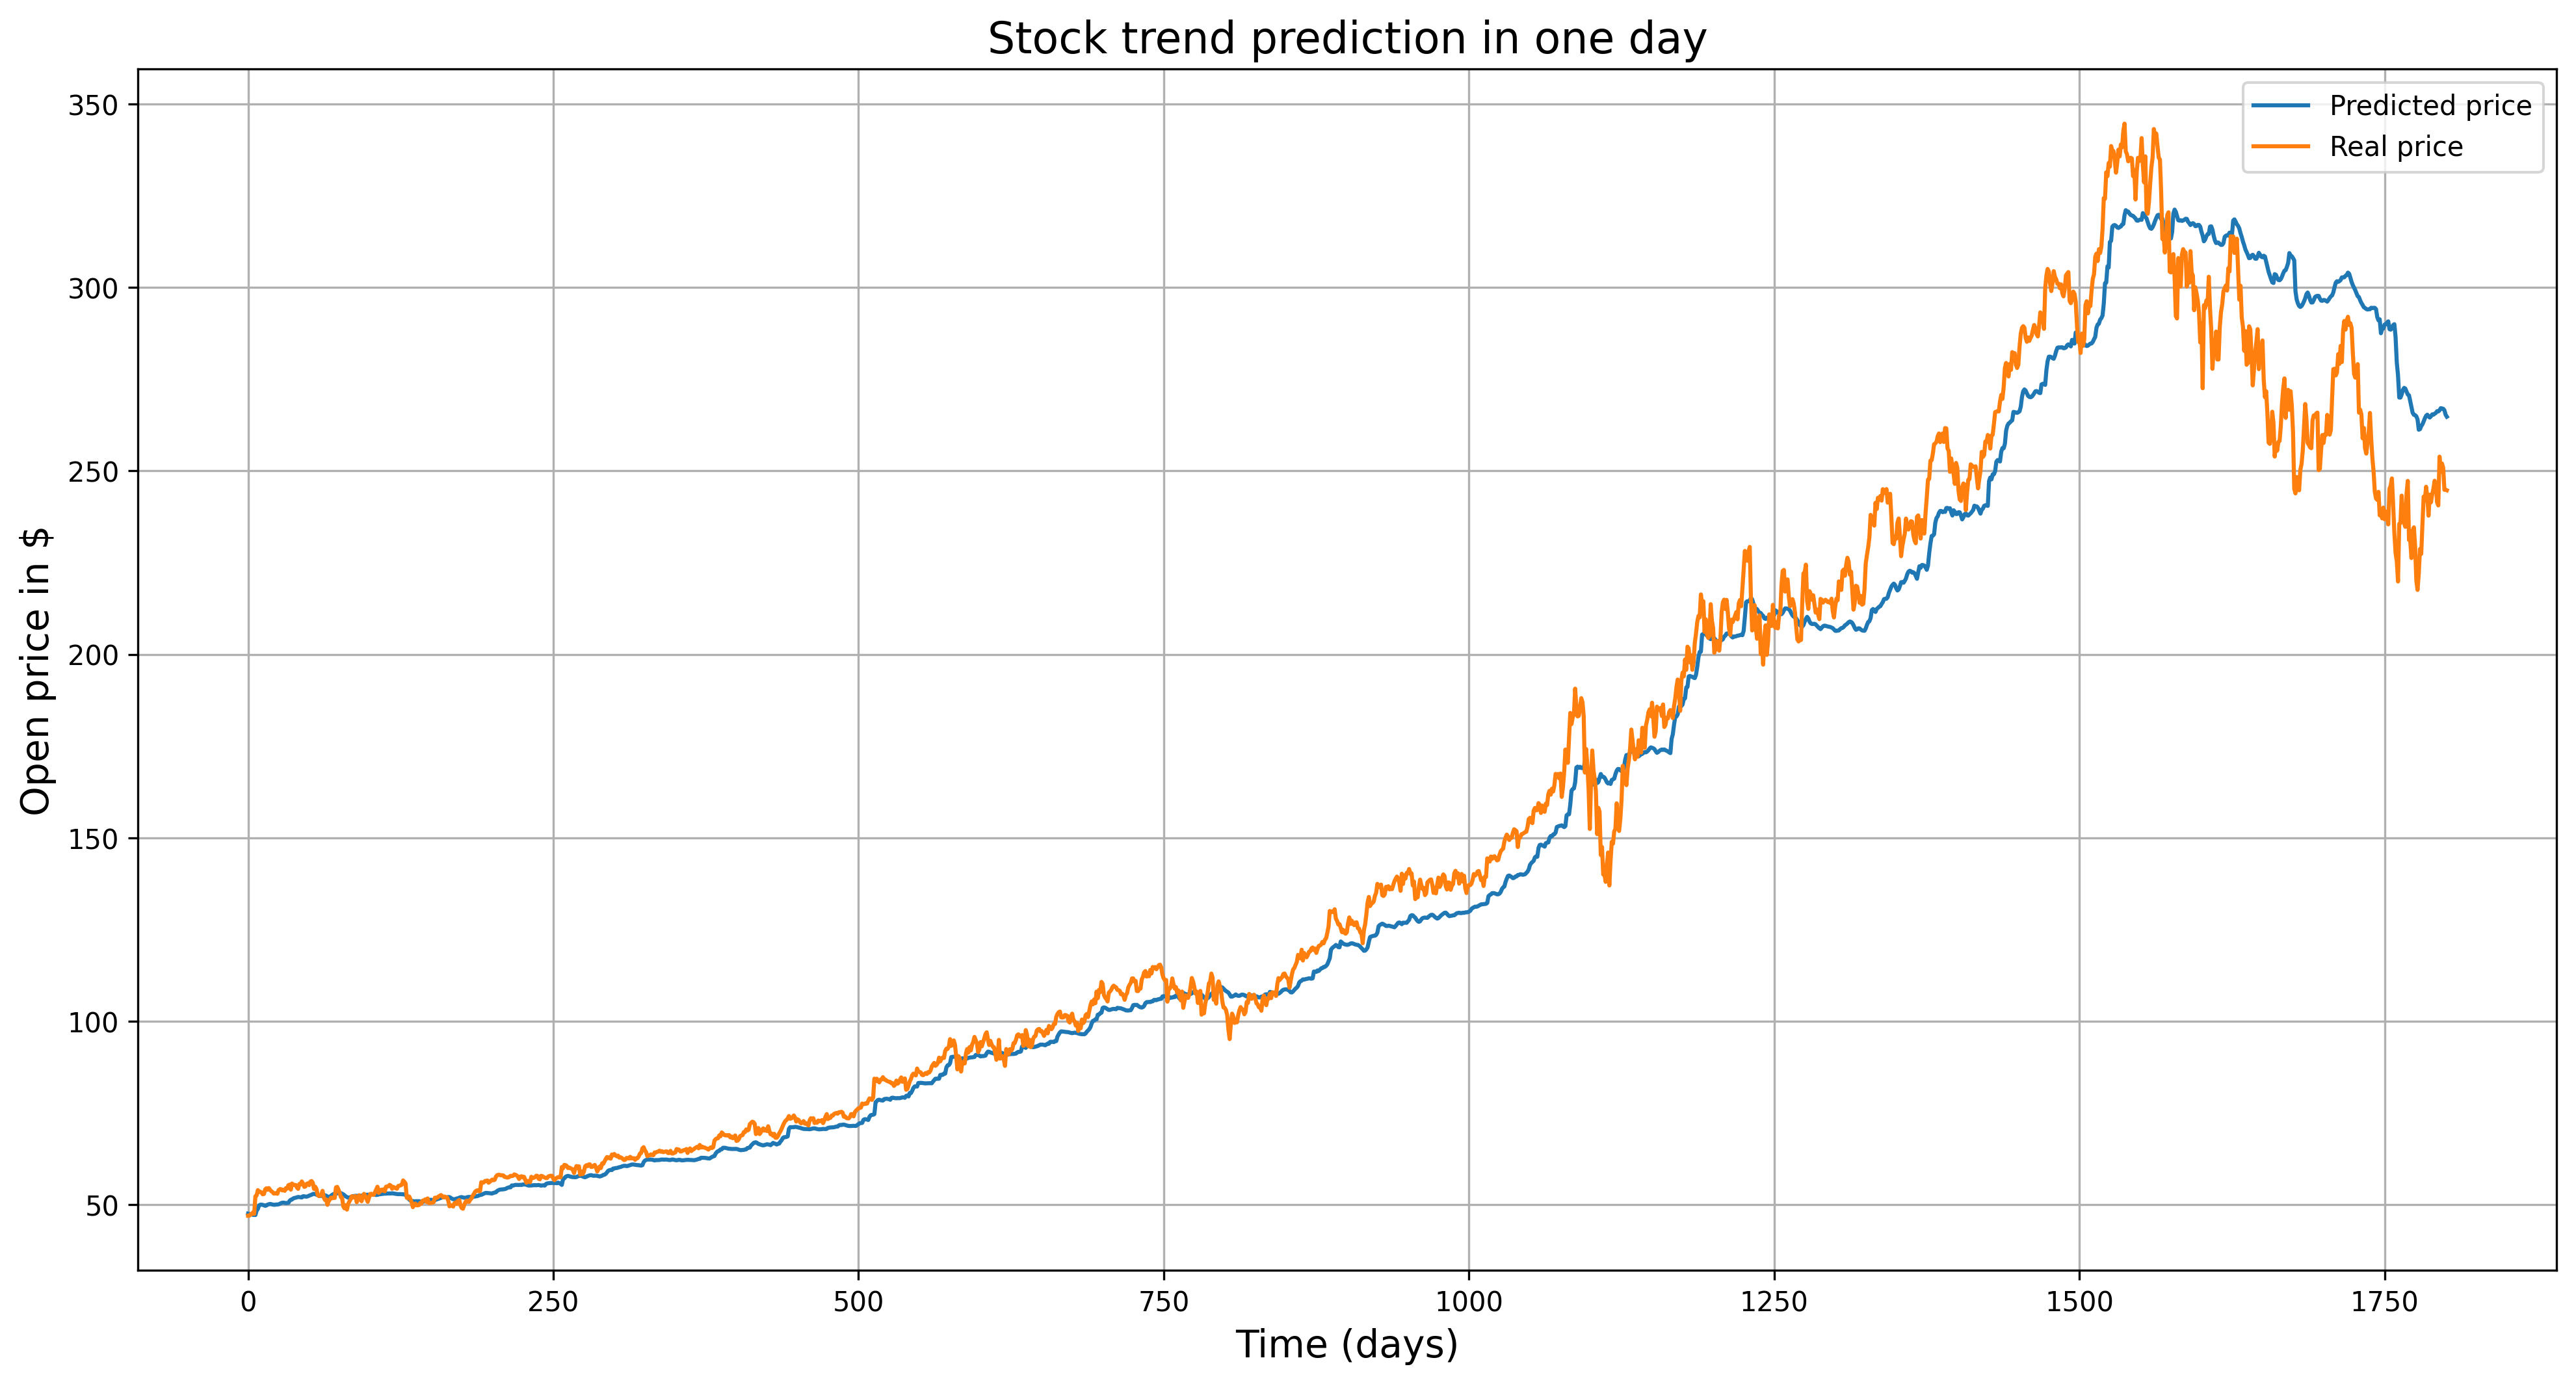

In [50]:
pred_real_visualize(y_pred_norm, X_test, y_test)

## 1.2 CROSS VALIDATION

In [51]:
X_data, y_data = preprocess_crossval(df, window_size)

# # Normalize the data
# X_data_norm, y_data_norm = MinMax_normalize(X_data, y_data)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=folds)

for train_index, test_index in tscv.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
    
    X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

    # Fit the model to the current training fold
    GRU_model.fit(X_train_norm, y_train_norm, epochs=epochs, batch_size=batch_size)
    
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

Epoch 1/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0026 - mse: 0.0026
Epoch 2/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0026 - mse: 0.0026
Epoch 3/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0026 - mse: 0.0026
Epoch 4/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0026 - mse: 0.0026
Epoch 5/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0026 - mse: 0.0026
Epoch 6/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0026 - mse: 0.0026
Epoch 7/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0026 - mse: 0.0026
Epoch 8/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0026 - mse: 0.0026
Epoch 9/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0026 - mse: 0.0026
Epoch 10/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0026 - mse: 0.0026
Epoch 11/200
1/1 [==============================] - 0s 49ms/step - lo

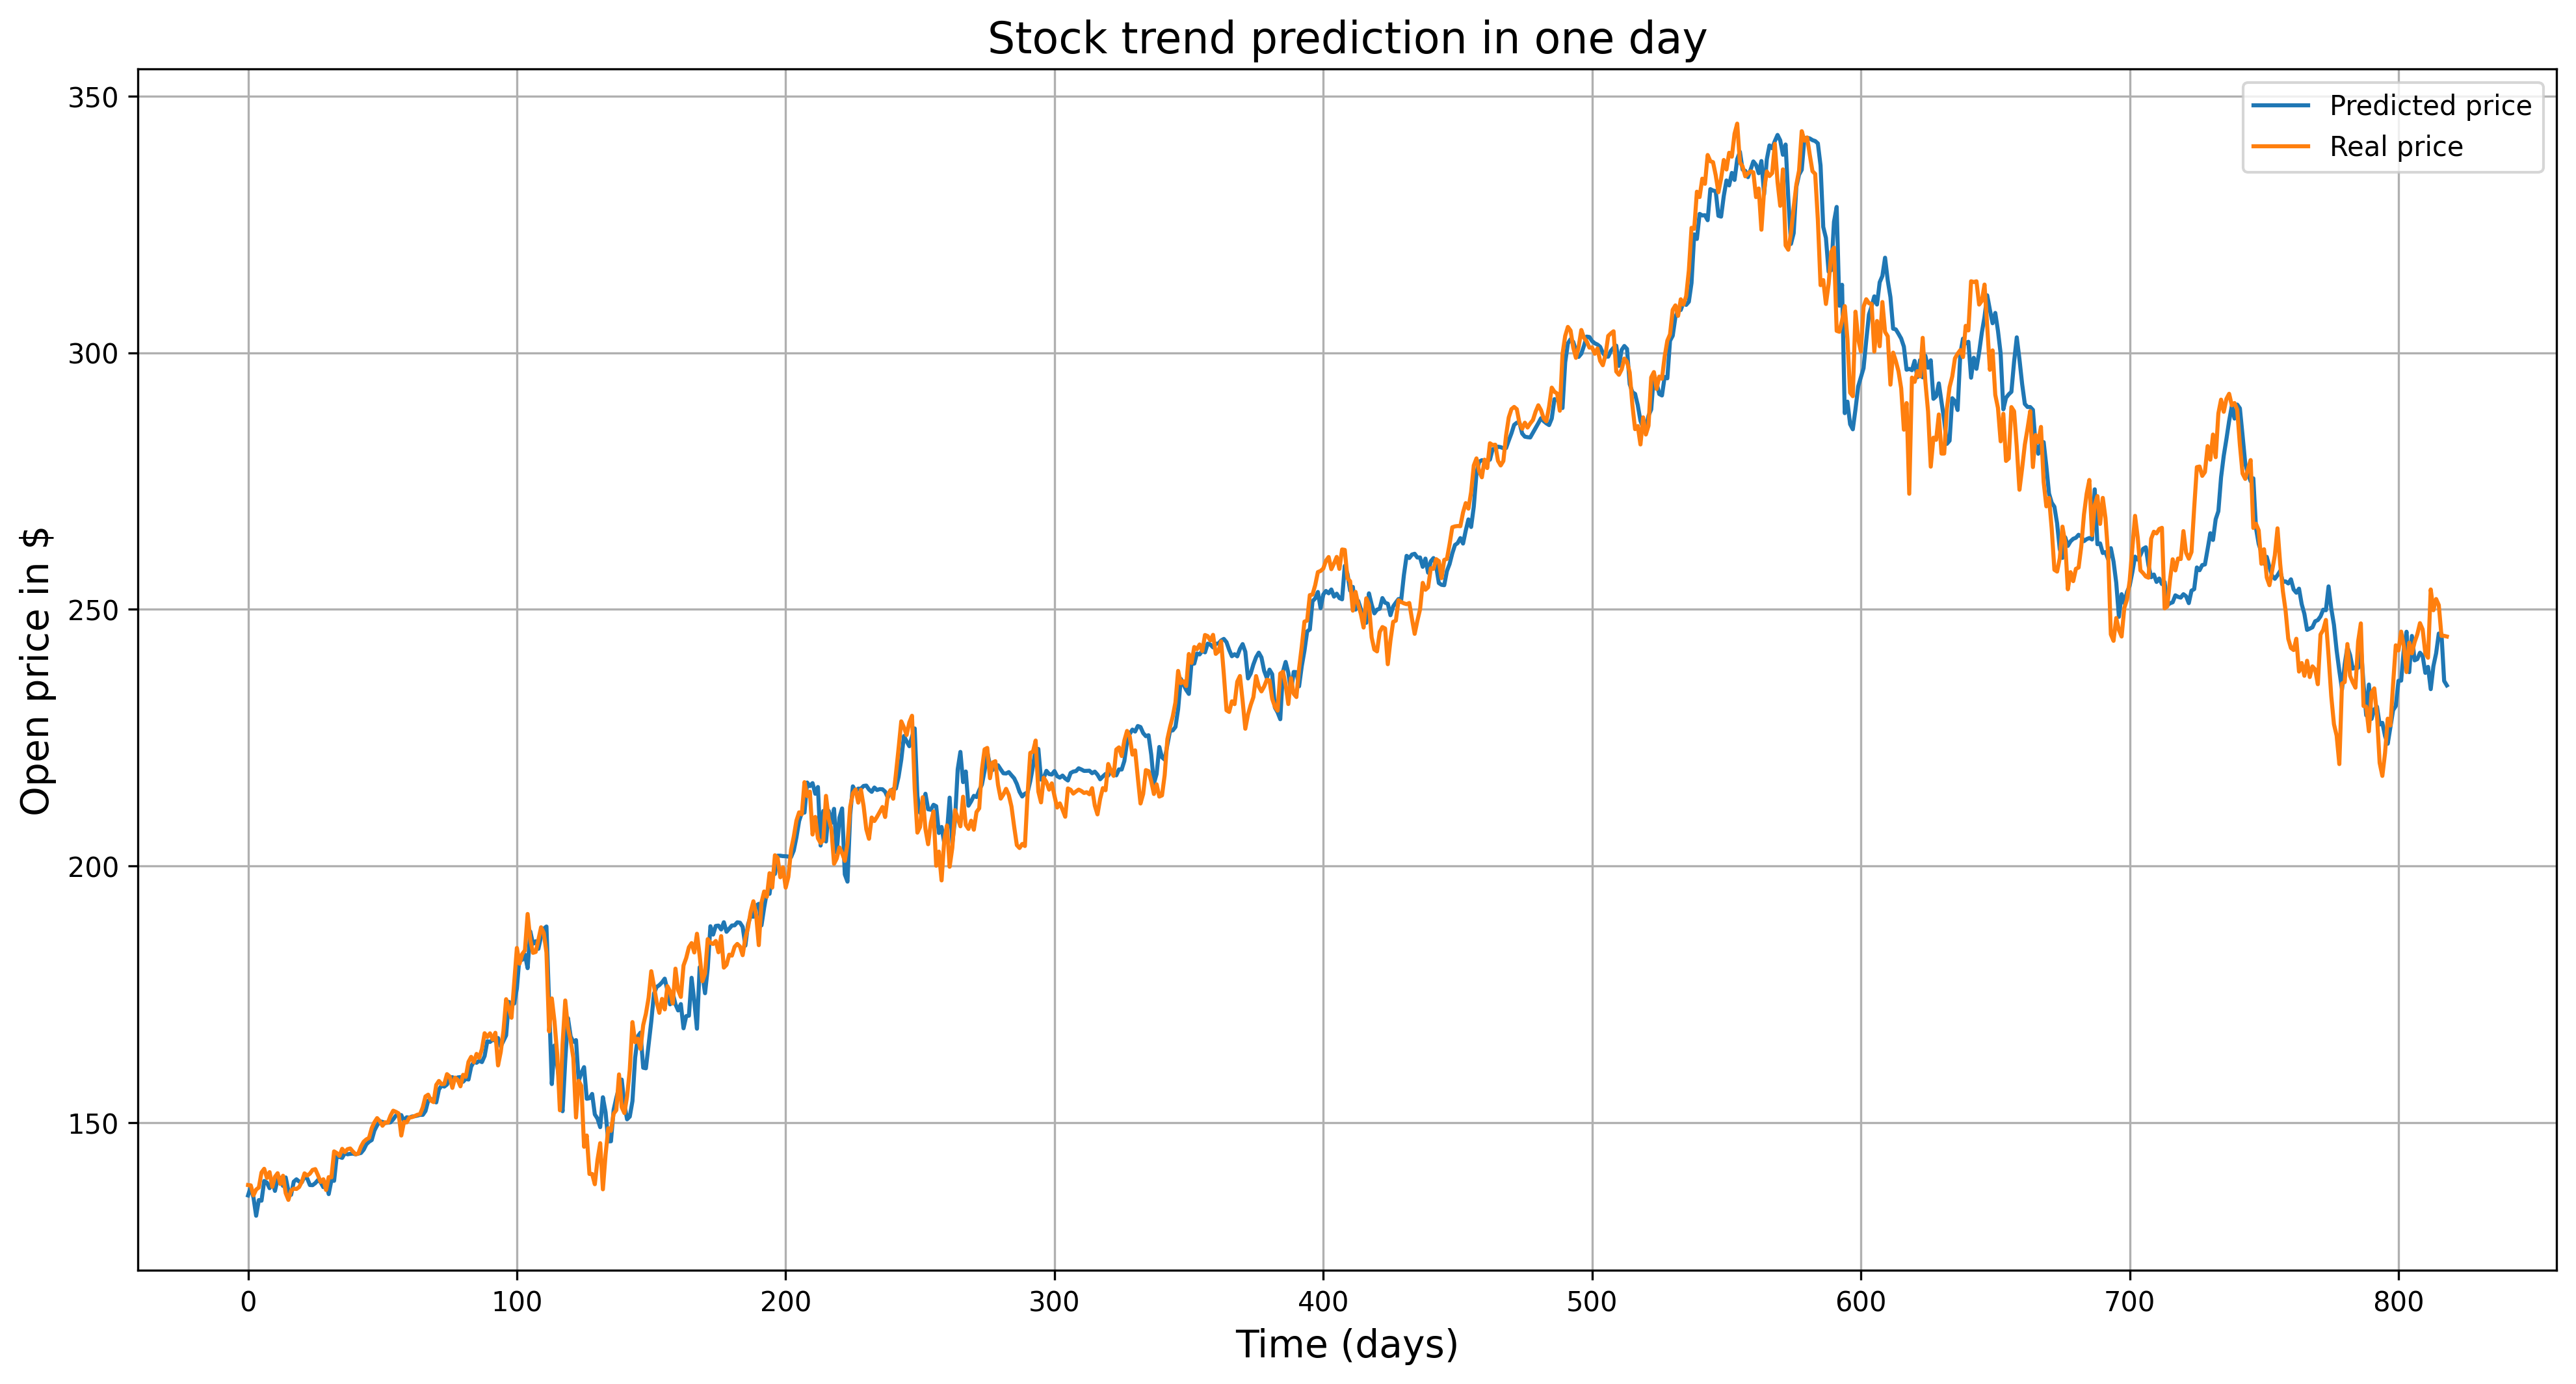

In [52]:
pred_real_visualize(y_pred_norm, X_test, y_test)